# Disease_Similarity_Benchmark

## Load Data

In [ ]:
%load ../scripts/variables.txt

In [14]:
import obonet
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame
import logging, sys, os
from tqdm import tqdm
import numpy as np, pandas as pd
from tqdm.contrib.concurrent import process_map
import pickle
import random

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


do_obl_data_path = os.path.join("..", "data", "DiseaseOntology", "doid.obo")
external_links_data_path = os.path.join(
    "..", "data", "DiSignAtlas", "external_links.pkl"
)


# load Disease Ontology network
do_graph = obonet.read_obo(do_obl_data_path)

# Convert to a NetworkX DIRECTED graph
do_G = nx.DiGraph(do_graph)

# map nodes to labels
do_2_label = {}
# Iterate through the nodes in the graph
for node, data in do_G.nodes(data=True):
    # Get the primary ID and name
    primary_id = node
    name = data.get("name", "No name")

    # Add primary ID to the mapping
    do_2_label[primary_id] = name

    # If there are alternative IDs, add them to the mapping as well
    alt_ids = data.get("alt_id", [])
    for alt_id in alt_ids:
        do_2_label[alt_id] = name

# load external links
with open(external_links_data_path, "rb") as f:
    external_links = pickle.load(f)

# get DOID for each dsa
dsaids_2_doids = {}
for dsaid, external_link in zip(
    external_links["dsaids"], external_links["external_links"]
):
    do_ids = [
        link.replace("DO:", "DOID:") for link in external_link if link.startswith("DO")
    ]
    if len(do_ids) > 0:
        dsaids_2_doids[dsaid] = do_ids

dsaids_with_doid = list(dsaids_2_doids.keys())

### Compute Similarities

In [9]:
def check_do_related(graph, nodes_1, nodes_2):
    """Check Distance
    Args:
        - graph (nx.Graph): graph
        - nodes_1 (list): list of nodes
        - nodes_2 (list): list of nodes
    Returns:
        - distances (list): distance
    """
    distances = list()
    related = False
    for node_1 in nodes_1:
        for node_2 in nodes_2:
            try:
                distance = nx.shortest_path_length(graph, source=node_1, target=node_2)
                related = True
                # distances.append(distance)
            except:
                pass
    return related


is_related = check_do_related(
    graph=do_G, nodes_1=dsaids_2_doids["DSA00040"], nodes_2=dsaids_2_doids["DSA00032"]
)

In [10]:
def check_common_mesh_terms(list_1, list_2, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - list_2 (list): list of mesh terms
        - level (int): level of mesh terms
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    list_2 = [
        ".".join(l.split(".")[:level]) for l in list_2 if len(l.split(".")) >= level
    ]
    if len(set(list_1).intersection(set(list_2))) > 0:
        return True
    else:
        return False

In [11]:
def check_mesh_level(list_1, level):
    """Check Common Mesh Terms
    Arguments:
        - list_1 (list): list of mesh terms
        - level (int): mesh level - 1 is root
    Returns:
        - (bool): True if common mesh terms
    """
    list_1 = [
        ".".join(l.split(".")[:level]) for l in list_1 if len(l.split(".")) >= level
    ]
    if len(list_1) >= 1:
        return True
    else:
        return False

In [ ]:
# c = 0
# level = 7
# for count, disease in enumerate(
#     tqdm(most_common_diseases)
# ):  # loop through diseases of interest
#     # dsaids w/ diseases of interest
#     related_dsaids = list()
#     unrrelated_dsaids = list()
#     dsaids_interest = disease_2_dsaid_filtered.get(disease)
#     _dsaids_interest_mesh_terms = list(
#         {
#             mesh_term
#             for d in dsaids_interest
#             for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
#         }
#     )
#     if check_mesh_level(_dsaids_interest_mesh_terms, level=level):
#         # print(disease)
#         c += 1

# print(c)

100%|██████████| 209/209 [00:00<00:00, 139166.46it/s]

41


In [12]:
def generate_matrix_idxs(interest_idxs, rest_idxs=None, bootstrap=False):
    """Generate pairs of indexes for a given list of indexes
    Arguments:
        - interest_idxs (list): list of indexes
        - rest_idxs (list): list of indexes
    Yields:
        - list: list of pairs of indexes
    """

    if rest_idxs is None:  # generate idxs agains itself
        matrix = np.empty((len(interest_idxs), len(interest_idxs) - 1, 2), dtype=int)
        rest_idxs = interest_idxs
    else:
        matrix = np.empty((len(interest_idxs), len(rest_idxs), 2), dtype=int)

    if bootstrap:
        # this is bc when we compare same samples we
        # remove itself - so we do the same here
        n_sample_idxs = len(interest_idxs)
        matrix = np.empty((len(interest_idxs), n_sample_idxs * 100, 2), dtype=int)
        # generate bootstrap indexes
        sample_idxs = np.empty(n_sample_idxs * 100, dtype=int)
        for i in range(100):
            _sample = np.random.choice(rest_idxs, size=n_sample_idxs, replace=True)
            sample_idxs[i * n_sample_idxs : (i + 1) * n_sample_idxs] = _sample

        # redefine rest indexes
        rest_idxs = sample_idxs

    for i, idx_interest in enumerate(interest_idxs):
        j = 0
        for idx_other in rest_idxs:
            if idx_interest != idx_other:  # in case that it is the same list
                matrix[i, j] = [idx_interest, idx_other]
                j += 1
    return matrix

In [23]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import random


def check_old_method_correlation(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]
    # Pearson Correlation
    correlation_matrix = np.corrcoef(matrix_interest)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(correlation_matrix, k=1)
    correlation_values = correlation_matrix[upper_triangular_indices]
    return np.mean(correlation_values)


def check_old_method_cosine(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="cosine")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)


def check_old_method_euclidean(dsaids_interest, data_matrix):
    """Check old method
    Arguments:
        - dsais_interest (list): list of dsais
    Returns:
        - correlation_values (list): correlation list
    """
    # idxs of interest
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

    # matrix interest
    matrix_interest = data_matrix[interest_idxs]

    # Compute pairwise distances within data_matrix_1
    distance_matrix = pdist(matrix_interest, metric="euclidean")
    # Convert to square form to make it consistent with the cdist output
    distance_matrix = squareform(distance_matrix)

    # Extract the upper triangular part of the correlation matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    distance_values = distance_matrix[upper_triangular_indices]

    return np.mean(distance_values)

In [32]:
# variables
k_top = 1
k_percent = 0.2
mesh_level = 1
bootstrap = True
n_diseases = 0

correlation_values_interest_all = list()
correlation_values_related_all = list()
correlation_values_unrelated_all = list()

cosine_values_interest_all = list()
cosine_values_related_all = list()
cosine_values_unrelated_all = list()

euclidean_values_interest_all = list()
euclidean_values_related_all = list()
euclidean_values_unrelated_all = list()

# get values
quality_check = random.choice(list(range(len(most_common_diseases))))
logging.info(f"Quality check: {quality_check} {most_common_diseases[quality_check]}")

all_indexes = set(range(data_matrix.shape[0]))

for count, disease in enumerate(tqdm(most_common_diseases)):

    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    related_dsaids = list()
    unrelated_dsaids = list()

    # get all doid terms unique to this disease
    _dsaids_interest_doids = list(
        {doid for d in dsaids_interest for doid in dsaids_2_doids.get(d, [])}
    )

    # Extract the specific vectors using the list of indexes
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    # interest indexes pairs
    """We have a list of lists in which we have
    for each disease signature of interest (row of a matrix) a list in which 
    we will have all the combination of pairs"""

    n_interest = len(interest_idxs)

    # compute how many pairs we will have
    n_interest_unique = int(n_interest * (n_interest - 1) / 2)
    n_interest_all = int(n_interest * n_interest)

    interest_idxs_pairs = np.empty((n_interest, n_interest - 1, 2), dtype=int)
    interest_idxs_pairs_unique = np.empty((n_interest_unique, 2), dtype=int)

    # generate pairs (all vs all)
    matrix_interest_idxs_pairs = generate_matrix_idxs(interest_idxs, bootstrap=False)

    # define matrix to store values
    matrix_correlation_values_interest = np.empty(
        (n_interest, n_interest - 1), dtype=float
    )

    matrix_cosine_values_interest = np.empty((n_interest, n_interest - 1), dtype=float)

    matrix_euclidean_values_interest = np.empty(
        (n_interest, n_interest - 1), dtype=float
    )

    # itereate through all interest signatures
    for i, row_interest in enumerate(matrix_interest_idxs_pairs):
        # get values
        correlation_values_interest = matrix_pearson_correlation[
            row_interest[:, 0], row_interest[:, 1]
        ]
        cosine_values_interest = matrix_cosine_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]
        euclidean_values_interest = matrix_euclidean_distance[
            row_interest[:, 0], row_interest[:, 1]
        ]

        # store values
        matrix_correlation_values_interest[i] = correlation_values_interest
        matrix_cosine_values_interest[i] = cosine_values_interest
        matrix_euclidean_values_interest[i] = euclidean_values_interest

    # quality check
    if count == quality_check:

        # check pearson correlation
        old_value_correlation = check_old_method_correlation(
            dsaids_interest, data_matrix
        )
        assert "%.7f" % old_value_correlation == "%.7f" % np.mean(
            matrix_correlation_values_interest
        ), "Err something wrong computing correlation"

        # check cosine distance
        old_value_cosine = check_old_method_cosine(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_cosine == "%.7f" % np.mean(
            matrix_cosine_values_interest
        ), "Err something wrong computing cosine"
        # check euclidean distance
        old_value_euclidean = check_old_method_euclidean(dsaids_interest, data_matrix)
        assert "%.7f" % old_value_euclidean == "%.7f" % np.mean(
            matrix_euclidean_values_interest
        ), "Err something wrong computing euclidean"

    # get rest indexes
    # get ids of rest
    _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

    # classify rest of ids into related or unrelated
    for dsaid in _rest_dsaids:
        doids = dsaids_2_doids.get(dsaid, [])
        # dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
        # check if they are related
        if check_do_related(
            do_G,
            _dsaids_interest_doids,
            doids,
        ):
            related_dsaids.append(dsaid)

        else:
            unrelated_dsaids.append(dsaid)
    if len(related_dsaids) > 0:
        n_diseases += 1
        # get idx position related and unrelated
        related_idxs = [dsaids_matrix.index(d) for d in related_dsaids]
        unrelated_idxs = [dsaids_matrix.index(d) for d in unrelated_dsaids]

        # get nº
        n_related = len(related_idxs)
        n_unrelated = len(unrelated_idxs)

        # generate matrix indexes pairs
        matrix_related_idxs_pairs = generate_matrix_idxs(
            interest_idxs, related_idxs, bootstrap=bootstrap
        )
        matrix_unrelated_idxs_pairs = generate_matrix_idxs(
            interest_idxs, unrelated_idxs, bootstrap=bootstrap
        )

        # define matrix to store values
        n_columns = (n_interest) * 100 if bootstrap else n_related
        matrix_correlation_values_related = np.empty(
            (n_interest, n_columns), dtype=float
        )
        matrix_cosine_values_related = np.empty((n_interest, n_columns), dtype=float)
        matrix_euclidean_values_related = np.empty((n_interest, n_columns), dtype=float)

        # iterate through all interest signature pairs
        for idx, row_related in enumerate(matrix_related_idxs_pairs):

            # get values
            correlation_values_related = matrix_pearson_correlation[
                row_related[:, 0], row_related[:, 1]
            ]
            cosine_values_related = matrix_cosine_distance[
                row_related[:, 0], row_related[:, 1]
            ]
            euclidean_values_related = matrix_euclidean_distance[
                row_related[:, 0], row_related[:, 1]
            ]

            # store values
            matrix_correlation_values_related[idx] = correlation_values_related
            matrix_cosine_values_related[idx] = cosine_values_related
            matrix_euclidean_values_related[idx] = euclidean_values_related

        # define matrix to store values
        n_columns = (n_interest) * 100 if bootstrap else n_unrelated
        matrix_correlation_values_unrelated = np.empty(
            (n_interest, n_columns), dtype=float
        )
        matrix_cosine_values_unrelated = np.empty((n_interest, n_columns), dtype=float)
        matrix_euclidean_values_unrelated = np.empty(
            (n_interest, n_columns), dtype=float
        )

        # iterate through all interest signature pairs to find top closest
        for idx, row_unrelated in enumerate(matrix_unrelated_idxs_pairs):

            # get correlation values
            correlation_values_unrelated = matrix_pearson_correlation[
                row_unrelated[:, 0], row_unrelated[:, 1]
            ]
            cosine_values_unrelated = matrix_cosine_distance[
                row_unrelated[:, 0], row_unrelated[:, 1]
            ]
            euclidean_values_unrelated = matrix_euclidean_distance[
                row_unrelated[:, 0], row_unrelated[:, 1]
            ]

            # get matrix to store values
            matrix_correlation_values_unrelated[idx] = correlation_values_unrelated
            matrix_cosine_values_unrelated[idx] = cosine_values_unrelated
            matrix_euclidean_values_unrelated[idx] = euclidean_values_unrelated

        # store all computed values
        correlation_values_interest_all.append(matrix_correlation_values_interest)
        correlation_values_related_all.append(matrix_correlation_values_related)
        correlation_values_unrelated_all.append(matrix_correlation_values_unrelated)

        cosine_values_interest_all.append(matrix_cosine_values_interest)
        cosine_values_related_all.append(matrix_cosine_values_related)
        cosine_values_unrelated_all.append(matrix_cosine_values_unrelated)

        euclidean_values_interest_all.append(matrix_euclidean_values_interest)
        euclidean_values_related_all.append(matrix_euclidean_values_related)
        euclidean_values_unrelated_all.append(matrix_euclidean_values_unrelated)

assert (
    n_diseases
    == len(correlation_values_interest_all)
    == len(correlation_values_unrelated_all)
), "Err something wrong with the length of the lists"

logging.info(f"Nº diseases evaluated {n_diseases}")

2024-06-03 16:16:38,721 - INFO - Quality check: 70 Acute Myeloid Leukemia (Aml-M2)
100%|██████████| 216/216 [00:56<00:00,  3.84it/s]
2024-06-03 16:17:34,940 - INFO - Nº diseases evaluated 175


In [33]:
# get total nº of diseases w/ 5+ signatures
n_processed_filtered = 0
for disease in df_data_info_processed_filtered["disease"].unique():
    QUERY = f"disease == @disease"
    df_query = df_data_info_processed_filtered.query(f"disease == @disease")
    if df_query.shape[0] >= 5:
        n_processed_filtered += 1

logging.info(f"Nº of disease 5+ signatures {n_processed_filtered}")

2024-06-03 16:17:35,785 - INFO - Nº of disease 5+ signatures 276


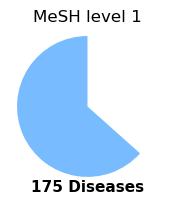

In [34]:
import matplotlib.pyplot as plt

# plot how many diseases we are evaluating here
n_processed_filtered
n_diseases

# Data preparation
sizes = [n_diseases, n_processed_filtered - n_diseases]  # Sizes for each slice

# Colors, setting the non-relevant slice to be 'none' (transparent)
colors = ["#78bcffff", "none"]

# Plotting the pie chart
plt.figure(figsize=(2, 2))  # Set the figure size
plt.pie(sizes, colors=colors, startangle=90)
plt.title(f"MeSH level {mesh_level}", fontsize=12)

plt.text(
    -0.8, -1.2, f"{n_diseases} Diseases", fontsize=11, fontweight="bold"
)  # Big title
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pie_chart.mesh_{mesh_level}.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

In [35]:
dsaids_2_disease = {v: k for k, vs in disease_2_dsaid_filtered.items() for v in vs}

diseases_matrix = [dsaids_2_disease.get(d) for d in dsaids_matrix]

In [ ]:
most_common_diseases[1]

# get disease of interest
dsaids_interest = disease_2_dsaid_filtered.get(most_common_diseases[1])

index = [dsaids_matrix.index(d) for d in dsaids_interest]

# get matrix values
values = matrix_pearson_correlation[index, :]

In [ ]:
[
    a
    for a in np.where(matrix_cosine_distance[370] > 1.8, diseases_matrix, None)
    if a is not None
]

[]

In [ ]:
# garbage collection
# do a bit of cleaning here and there !
import gc

# collect garbage
cleaning = gc.collect()

cleaning

20535

### Plots

In [41]:
# imports
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array
from scipy.interpolate import make_interp_spline


# functions
def get_top_k(array, k, percent=False, reverse=False):
    """Get top k values
    Arguments:
        - array (numpy): array of values
        - k_percent (float): percentage of top k values
    Returns:
        - top_k_values (numpy): array of top k values
    """
    if percent:
        k = round(k * array.shape[0])
    if reverse:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[:k]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        bottom_k_values_from_indices = array[indices]
        return bottom_k_values_from_indices
    else:
        # Using numpy.argsort to get indices of the k top highest values
        indices = np.argsort(array)[-k:]

        # # Sorting indices if you want them in the order of the corresponding values
        # sorted_indices = indices[np.argsort(array[indices])][::-1]

        # Getting the top k values using the sorted indices
        # top_k_values_from_indices = array[sorted_indices]
        top_k_values_from_indices = array[indices]
        return top_k_values_from_indices

In [42]:
def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def create_composite_histogram(distributions, bin_edges, is_list=False):
    """
    Create a composite histogram from multiple distributions.

    Parameters:
    - distributions: List of arrays, each representing a distribution of points.
    - bin_edges: Array of bin edges to use for all histograms.

    Returns:
    - composite_histogram: The composite histogram (sum of normalized histograms).
    """
    # Initialize an array to hold the sum of all normalized histograms
    counts_composite_histogram = np.zeros_like(bin_edges[:-1], dtype=float)

    # Iterate over each distribution
    for dist in distributions:
        if is_list:
            dist_values = flatten(dist)
        else:
            dist_values = dist.flatten()
        # Calculate the histogram for this distribution
        counts, _ = np.histogram(dist_values, bins=bin_edges)

        # Normalize the histogram by the number of points in the distribution
        normalized_counts = counts / len(dist_values)

        # Add the normalized histogram to the composite histogram
        counts_composite_histogram += normalized_counts

    return counts_composite_histogram

In [49]:
def format_p_value_std(mean, std):
    """Format the mean and standard deviation. Append an asterisk if mean < 0.05."""
    formatted_mean = f"{mean:.4e}" if mean < 0.0001 else f"{mean:.4f}"
    formatted_std = f"{std:.4e}" if std < 0.0001 else f"{std:.4f}"
    return f"{formatted_mean}±{formatted_std}" + ("*" if mean < 0.05 else "")


def format_p_value(mean):
    """Format the mean and standard deviation. Append an asterisk if mean < 0.05."""
    formatted_mean = f"{mean:.4e}" if mean < 0.0001 else f"{mean:.4f}"
    return f"{formatted_mean}" + ("*" if mean < 0.05 else "")


def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std


def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    mesh_level,
    cap_value=None,
    save=True,
    sparsity="HS",
    figsize=(4.5, 3),
    values_per_disease=True,
):

    # define variables

    colors = {0: "#FF7F50", 1: "#AFEAAA", 2: "#1E90FF"}
    colors = {0: "#FE8402", 1: "#87E293", 2: "#1E90FF"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1.01, 0.05),
        "pearson": np.arange(-1, 1.01, 0.05),
        "cosine": np.arange(0, 2.01, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=figsize)

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 0.5

        if values_per_disease:
            # compute normalized density counts for each distribution
            counts = create_composite_histogram(values, fixed_bins)
        else:
            counts, _ = np.histogram(values, bins=fixed_bins)
            counts = counts / len(values)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt

    # Formatting each p-value mean and std, and constructing parts of the title

    formatted_parts = [format_p_value_std(mean, std) for mean, std in ks_values_list]

    # Constructing the full title
    title = (
        "Same-Related KS p-value: {}\n"
        "Same-Unrelated KS p-value: {}\n"
        "Related-Unrelated KS p-value: {}"
    ).format(*formatted_parts)

    plt.title(title, fontsize=10)
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}.{filtering}.mesh_{mesh_level}.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

In [43]:
np.max(np.arange(-1, 1.01, 0.05))

1.0000000000000018

In [44]:
def get_ks_statistics_subsamples_all(
    list_matrix_1, list_matrix_2, resampling_1=False, resampling_2=True
):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_means = list()
    for i in range(len(list_matrix_1)):
        # mean of statistics within a diseases
        if resampling_1 & resampling_2:
            ks_p_values_mean_disease = np.mean(
                [
                    ks_2samp(s_p_1, s_p_2.flatten())[1]
                    for (s_p_1, s_p_2) in zip(list_matrix_1[i], list_matrix_2[i])
                ]
            )
        elif resampling_2 & (not resampling_1):
            p_1 = list_matrix_1[i].flatten()
            ks_p_values_mean_disease = np.mean(
                [ks_2samp(p_1, s_p_2.flatten())[1] for s_p_2 in list_matrix_2[i]]
            )
        elif (not resampling_1) & (not resampling_2):
            p_1 = list_matrix_1[i].flatten()
            p_2 = list_matrix_2[i].flatten()
            ks_p_values_mean_disease = ks_2samp(p_1, p_2)[1]

        ks_p_values_means.append(ks_p_values_mean_disease)

    ks_p_values_mean_of_means = np.mean(ks_p_values_means)
    ks_p_values_std_of_means = np.std(ks_p_values_means)

    return ks_p_values_mean_of_means, ks_p_values_std_of_means

In [45]:
ks_2samp(
    correlation_values_interest_all[0].flatten(),
    correlation_values_interest_all[0].flatten(),
)[1]

1.0

#### Pearson Correlations

In [52]:
# pearson correlation all
# Correlation values mean with
value_1 = correlation_values_interest_all
value_2 = correlation_values_related_all
value_3 = correlation_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Compute KS statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_related_all,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_interest_all,
    list_matrix_2=correlation_values_unrelated_all,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=correlation_values_related_all,
    list_matrix_2=correlation_values_unrelated_all,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

2024-05-22 18:10:00,685 - INFO - Nº of values: 175 175


pearson
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]
p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01 

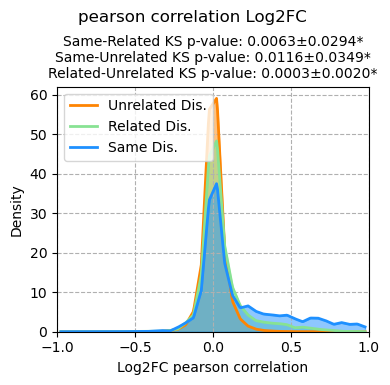

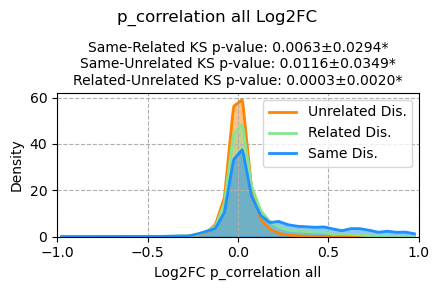

In [53]:
plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["pearson", "correlation"],
    save=False,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=False,
    mesh_level=mesh_level,
)

2024-05-22 18:07:11,461 - INFO - Nº of values: 175 175


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


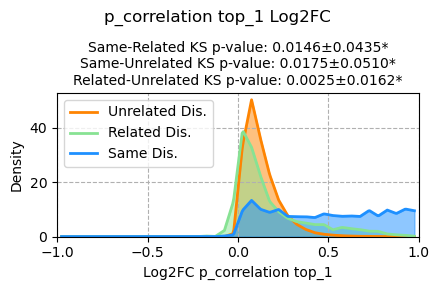

In [51]:
# pearson correlation top_1
# define values
top_k = 1

value_1 = list()
for matrix in correlation_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=False,
    mesh_level=mesh_level,
)

2024-05-22 18:15:25,238 - INFO - Nº of values: 175 175


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


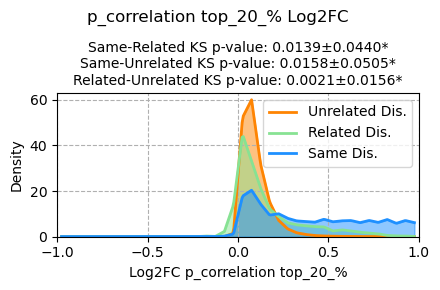

In [54]:
# pearson correlation top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in correlation_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in correlation_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in correlation_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# define statistics
# define statistics
ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]
fixed_bins = np.arange(-1.001, 1.001, 0.05)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_20_%"],
    save=False,
    mesh_level=mesh_level,
)

2024-05-08 13:07:25,276 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-05-08 13:07:28,184 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-05-08 13:07:31,156 - INFO - Nº of values: 209 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


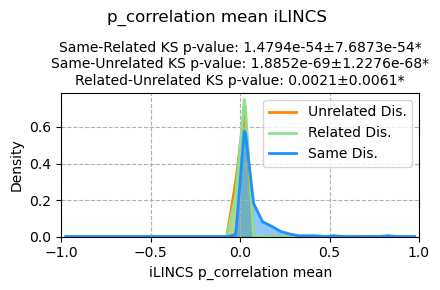

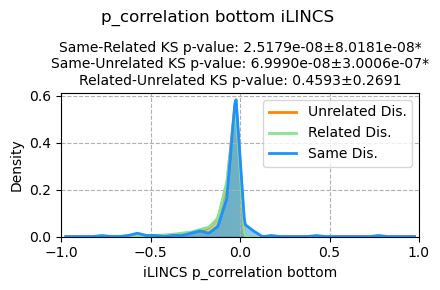

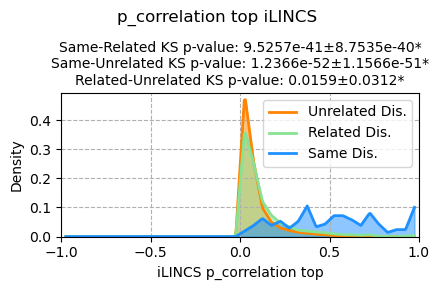

In [ ]:
# pearson correlation mean
# define values
operation_d = {"mean": np.mean, "bottom": np.min, "top": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [
        operation(matrix.flatten()) for matrix in correlation_values_interest_all
    ]

    value_2 = [[] for _ in range(100)]
    for matrix in correlation_values_related_all:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in correlation_values_unrelated_all:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["p_correlation", operation_type],
        save=True,
        mesh_level=mesh_level,
        values_per_disease=False,
    )

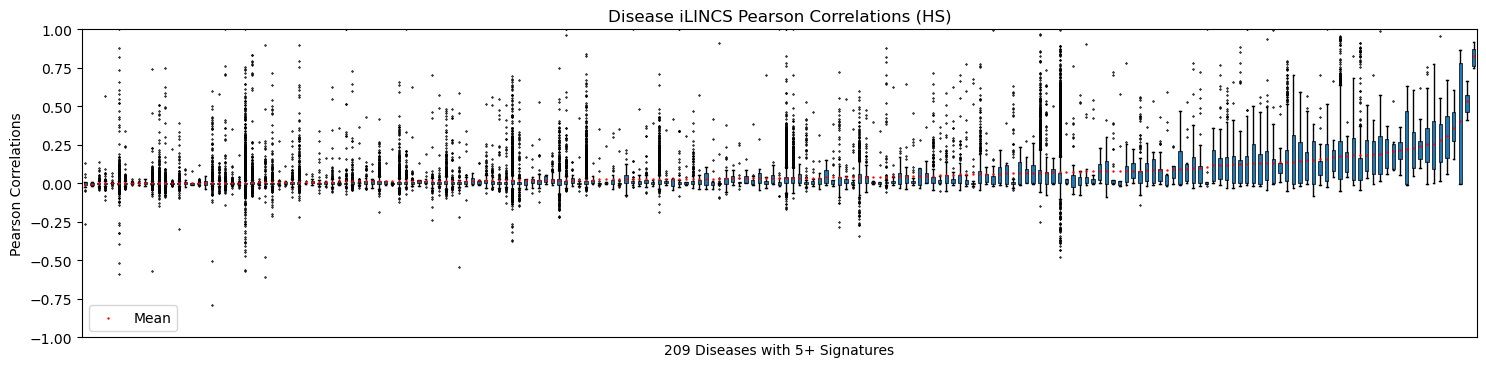

In [ ]:
# Plot Disease Pearson Correlations Boxplots
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = correlation_values_interest_all
# Calculate means and sort data based on these means
means = [np.mean(i) for i in data]
sorted_indices = np.argsort(means)
sorted_data = [data[i].flatten() for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_diseases = [most_common_diseases[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(18, 4))  # Adjusted for visibility

flierprops = dict(marker=".", color="black", markersize=0.8)  # Customizing outliers
boxprops = dict(linestyle="solid", linewidth=0.5, color="black")
medianprops = dict(linestyle="-", linewidth=0)
# Boxplot
bp = plt.boxplot(
    sorted_data,
    vert=True,
    patch_artist=True,
    positions=range(1, int(len(sorted_means) / 1) + 1),
    flierprops=flierprops,
    boxprops=boxprops,
    medianprops=medianprops,
    # Apply outlier customization
)  # Adjusted for visibility

# Overlay means
plt.scatter(
    range(1, int(len(sorted_means) / 1) + 1),
    sorted_means,
    color="red",
    zorder=3,
    label="Mean",
    s=0.5,
)  # Adjusted for visibility

# Customization
plt.title(f"Disease {metric_evaluated} Pearson Correlations ({sparsity})")
plt.xlabel(f"{len(means)} Diseases with 5+ Signatures")
plt.ylabel("Pearson Correlations")
plt.xticks([])
plt.legend()
plt.ylim(-1, 1)

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"boxplot.diseases_correlation.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

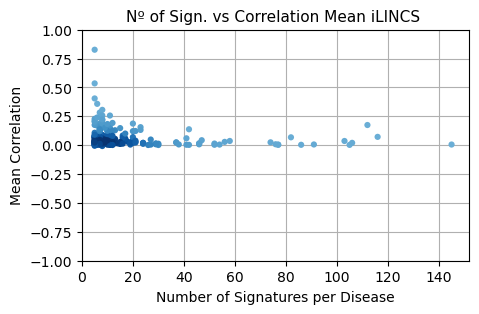

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in correlation_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Correlation Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Correlation")

plt.ylim(-1, 1)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.correlation.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Euclidean Distances

In [ ]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

2024-05-08 13:07:36,297 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]
euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460.

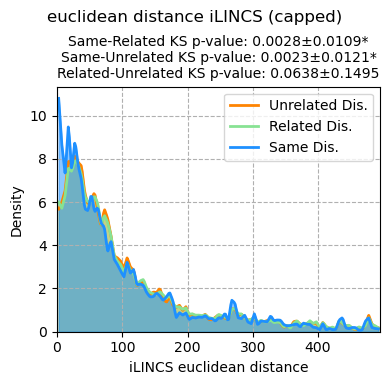

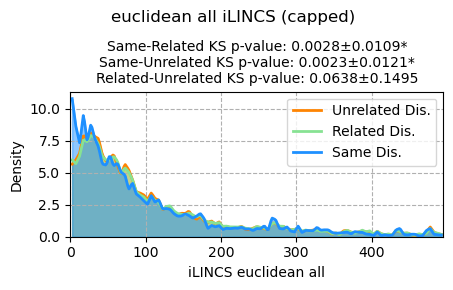

In [ ]:
# euclidean all
value_1 = euclidean_values_interest_all
value_2 = euclidean_values_related_all
value_3 = euclidean_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "distance"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]
euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460.

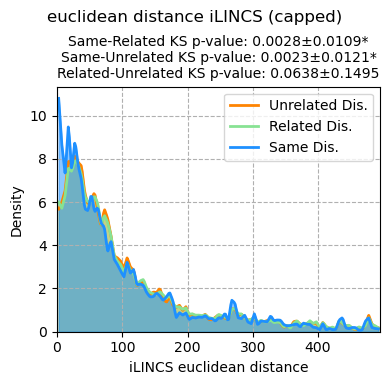

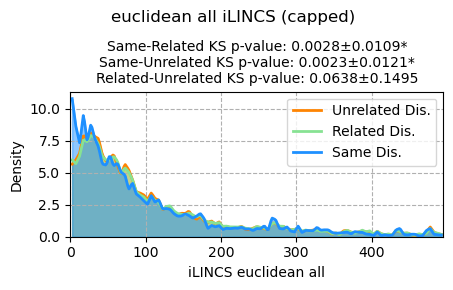

In [ ]:
plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "distance"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:12:10,971 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


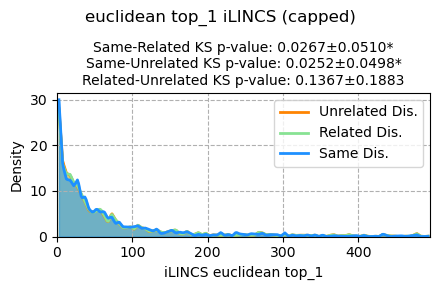

In [ ]:
# pearson euclidean top_1
# define values
top_k = 1

value_1 = list()
for matrix in euclidean_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_1"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:13:00,744 - INFO - Nº of values: 209 209


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


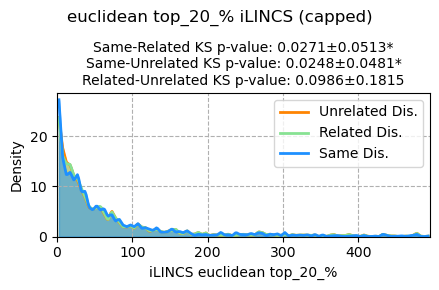

In [ ]:
# pearson euclidean top_20_%
# define values
top_k = 0.2

value_1 = list()
for matrix in euclidean_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in euclidean_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in euclidean_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

# Cap the values for each list
capped_value_1 = [cap_values_at_limit(v, cap_val) for v in value_1]
capped_value_2 = [cap_values_at_limit(v, cap_val) for v in value_2]
capped_value_3 = [cap_values_at_limit(v, cap_val) for v in value_3]

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_20_%"],
    cap_value=cap_val,
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:13:50,947 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-05-08 13:13:53,819 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-05-08 13:13:56,645 - INFO - Nº of values: 209 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


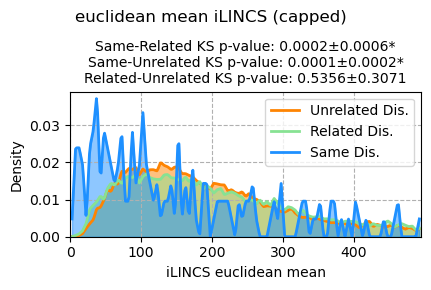

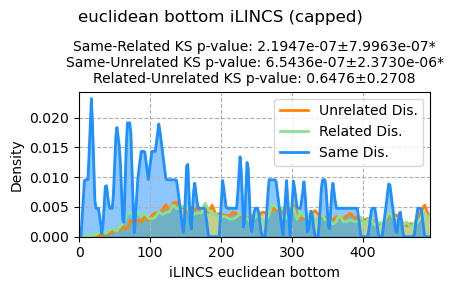

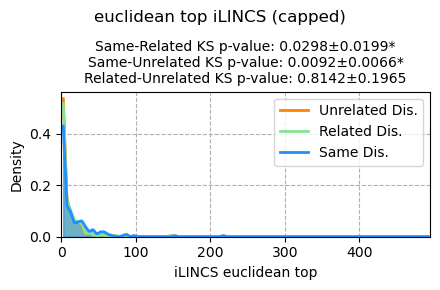

In [ ]:
# pearson euclidean mean
# define values
top_k = 0.2
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [operation(matrix.flatten()) for matrix in euclidean_values_interest_all]

    value_2 = [[] for _ in range(100)]
    for matrix in euclidean_values_related_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in euclidean_values_unrelated_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["euclidean", operation_type],
        save=True,
        mesh_level=mesh_level,
        cap_value=cap_val,
        values_per_disease=False,
    )

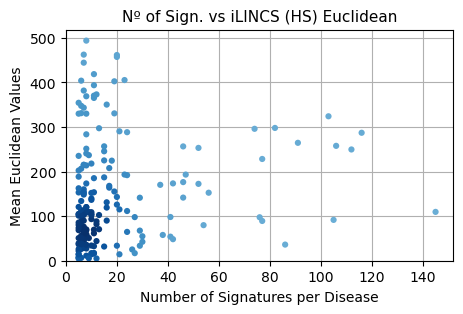

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = list()
n_signatures_per_disease = list()

for i in range(len(euclidean_values_interest_all)):
    value = np.mean(euclidean_values_interest_all[i])
    if value < cap_val:
        values_1.append(value)
        n_signatures_per_disease.append(
            len(disease_2_dsaid_filtered.get(most_common_diseases[i]))
        )


# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)

# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)

# Customization
plt.grid(True, zorder=-1)  # Add gridlines
plt.title(f"Nº of Sign. vs {metric_evaluated} ({sparsity}) Euclidean", fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Euclidean Values")
plt.xlim(
    0,
)
plt.ylim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.euclidean.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cosine Distances

In [ ]:
def get_ks_statistics_all(list_matrix_1, list_matrix_2):
    """Get KS Statistics All
    Arguments:
        - list_matrix_1 (list): list of matrices
        - list_matrix_2 (list): list of matrices
    Returns:
        - ks_p_values_mean (float): mean p-values
        - ks_p_values_std (float): std p-values
    """
    ks_p_values_mean = np.mean(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )
    ks_p_values_std = np.std(
        [
            ks_2samp(p_1.flatten(), p_2.flatten())[1]
            for p_1, p_2 in zip(list_matrix_1, list_matrix_2)
        ]
    )

    return ks_p_values_mean, ks_p_values_std

2024-05-08 13:13:57,228 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]
cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


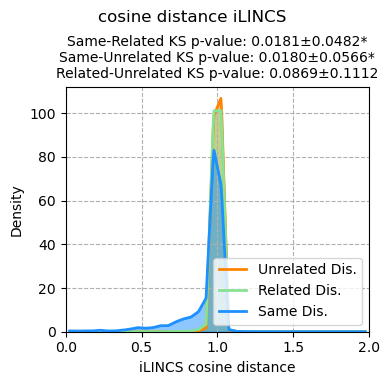

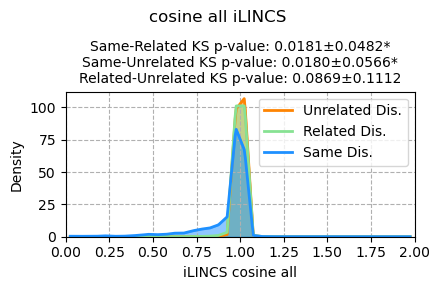

In [ ]:
# plot cosine all
# get values
value_1 = cosine_values_interest_all
value_2 = cosine_values_related_all
value_3 = cosine_values_unrelated_all
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "distance"],
    save=True,
    mesh_level=mesh_level,
    figsize=(4, 4),
)

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:16:47,285 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


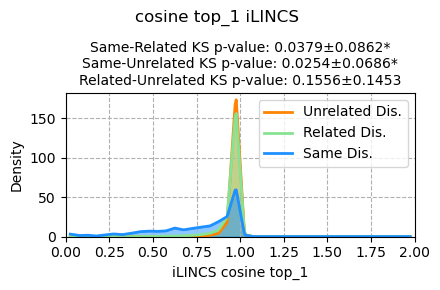

In [ ]:
# plot cosine top_1
# get values
top_k = 1

value_1 = list()
for matrix in cosine_values_interest_all:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_1"],
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:17:37,950 - INFO - Nº of values: 209 209
2024-05-08 13:17:37,950 - INFO - Nº of values: 209 209


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


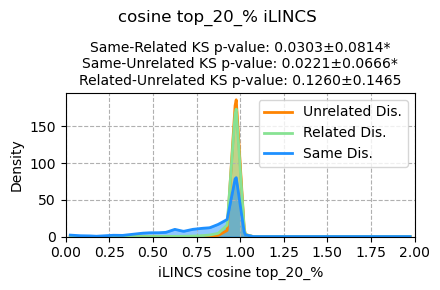

In [ ]:
# plot cosine top_20_%
# get values
top_k = 0.2

value_1 = list()
for matrix in cosine_values_interest_all:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_1.append(_matrix_values)

value_2 = list()
for matrix in cosine_values_related_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in cosine_values_unrelated_all:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")
logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

ks_p_values_i_r_mean, ks_p_values_i_r_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_i_u_mean, ks_p_values_i_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_1,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_r_u_mean, ks_p_values_r_u_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_2,
    list_matrix_2=value_3,
    resampling_1=True,
    resampling_2=True,
)


# Define plotting variables
values_list = [value_3, value_2, value_1]
ks_values_list = [
    [ks_p_values_i_r_mean, ks_p_values_i_r_std],
    [ks_p_values_i_u_mean, ks_p_values_i_u_std],
    [ks_p_values_r_u_mean, ks_p_values_r_u_std],
]

labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]


plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_20_%"],
    save=True,
    mesh_level=mesh_level,
)

2024-05-08 13:18:15,222 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-05-08 13:18:18,098 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-05-08 13:18:20,959 - INFO - Nº of values: 209 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


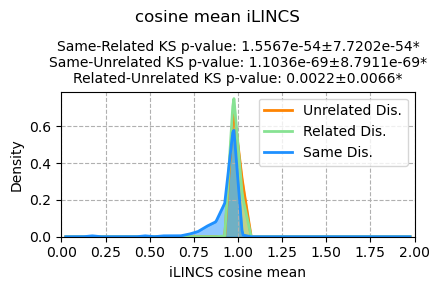

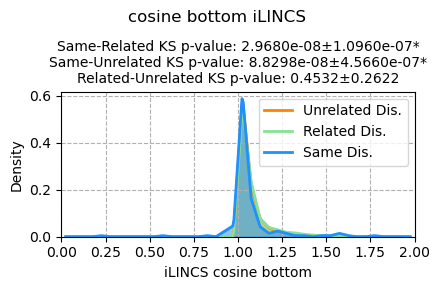

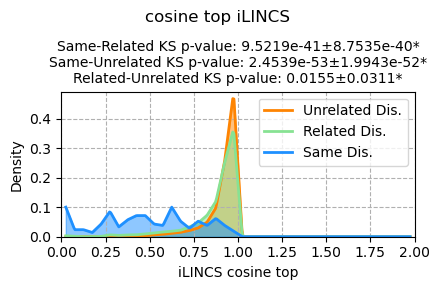

In [ ]:
# pearson cosine mean
# define values
top_k = 0.2
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_1 = [operation(matrix.flatten()) for matrix in cosine_values_interest_all]

    value_2 = [[] for _ in range(100)]
    for matrix in cosine_values_related_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in cosine_values_unrelated_all:
        n_columns = round(matrix.shape[1] / 100 * top_k)
        # iterate through rows
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_2[i])[1])
    ks_p_values_i_r_mean, ks_p_values_i_r_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_1, value_3[i])[1])
    ks_p_values_i_u_mean, ks_p_values_i_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_2[i], value_3[i])[1])
    ks_p_values_r_u_mean, ks_p_values_r_u_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [flatten(value_3), flatten(value_2), value_1]
    ks_values_list = [
        [ks_p_values_i_r_mean, ks_p_values_i_r_std],
        [ks_p_values_i_u_mean, ks_p_values_i_u_std],
        [ks_p_values_r_u_mean, ks_p_values_r_u_std],
    ]

    labels = ["Unrelated Dis.", "Related Dis.", "Same Dis."]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["cosine", operation_type],
        save=True,
        mesh_level=mesh_level,
        values_per_disease=False,
    )

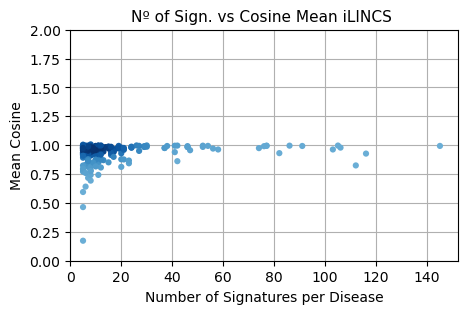

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

values_1 = [np.mean(i) for i in cosine_values_interest_all]

# number of signatures per disease
n_signatures_per_disease = [
    len(disease_2_dsaid_filtered.get(disease)) for disease in most_common_diseases
]

# Calculate the point density
xy = np.vstack([n_signatures_per_disease, values_1])
z = gaussian_kde(xy)(xy)

# Compute R-squared value
slope, intercept = np.polyfit(n_signatures_per_disease, values_1, 1)
r_squared = np.corrcoef(n_signatures_per_disease, values_1)[0, 1] ** 2

# Original Blues colormap
orig_cmap = plt.cm.Blues

# Create a custom colormap from a subset of the original colormap's range
# Adjust start and stop to control the range of colors used
start = 0.5  # Start from a darker shade
stop = 1  # End at the original colormap's maximum value
blues_custom = LinearSegmentedColormap.from_list(
    "Truncated Blues", orig_cmap(np.linspace(start, stop, 256))
)


# Plot
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    n_signatures_per_disease,
    values_1,
    c=z,
    s=20,
    edgecolor="none",
    cmap=blues_custom,
    zorder=3,
)


# Customization
plt.grid(True, zorder=-1)  # Add gridlines
title_txt = f"Nº of Sign. vs Cosine Mean {metric_evaluated} "
title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
plt.title(title_txt, fontsize=11)
# plt.title(f"Scatter Plot Colored by Density with R^2: {r_squared:.2f}")
plt.xlabel("Number of Signatures per Disease")
plt.ylabel("Mean Cosine")

plt.ylim(0, 2)
plt.xlim(
    0,
)
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"scatter_plot.cosine.mesh.{sparsity}.{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

#### Cherry-picked diseases: tSNE & Pearson Correlations

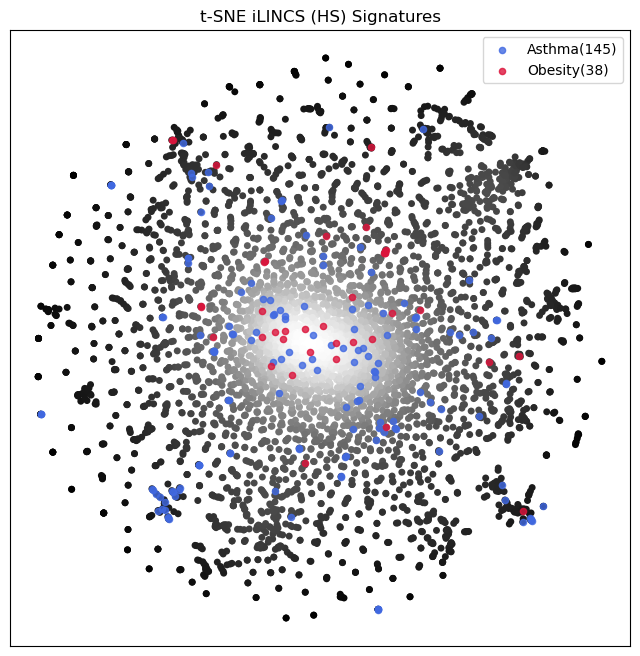

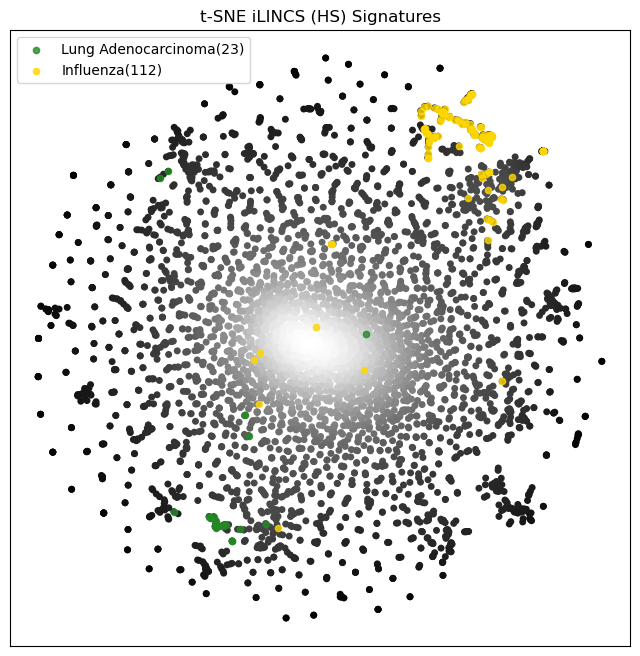

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

single_disease_examples = [
    "Asthma",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

colors_list = [["#4169E1", "#DC143C"], ["#228B22", "#FFD700"]]

for j, disease_sublist in enumerate(
    [
        ["Asthma", "Obesity"],
        ["Lung Adenocarcinoma", "Influenza"],
    ]
):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=10)

    colors = colors_list[j]
    data_matrix_copy = data_matrix.copy()

    embedded_data = tsne.fit_transform(data_matrix_copy)

    # Standardize the t-SNE embeddings (important for density calculation)
    scaler = StandardScaler()
    scaled_embedded_data = scaler.fit_transform(embedded_data)

    scaled_embedded_data = embedded_data

    # Calculate the density of points in the t-SNE space using Gaussian KDE
    bandwidth = 0.3  # Bandwidth parameter for KDE
    kde = gaussian_kde(scaled_embedded_data.T, bw_method=bandwidth)
    density = kde(scaled_embedded_data.T)

    # Create a scatter plot with colors based on local density
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        embedded_data[:, 0],
        embedded_data[:, 1],
        c=density,
        cmap="grey",
        s=25,
        edgecolor="none",
    )

    # specific indexes
    d_disease_2_index = dict()
    for i, disease in enumerate(disease_sublist):
        # dsaids w/ diseases of interest
        dsaids_interest = disease_2_dsaid_filtered.get(disease)

        # Extract the specific vectors using the list of indexes
        interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

        plt.scatter(
            embedded_data[interest_idxs, 0],
            embedded_data[interest_idxs, 1],
            color=colors[i],
            label=f"{disease}({len(interest_idxs)})",
            s=20,
            alpha=0.8,
        )

    plt.legend()
    # plt.colorbar(scatter, label="Local Density")
    plt.title(f"t-SNE {metric_evaluated} ({sparsity}) Signatures")
    # plt.xlabel("t-SNE Dimension 1")
    # plt.ylabel("t-SNE Dimension 2")
    plt.xticks([])
    plt.yticks([])

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"tsne.{sparsity}.{j}.{metric_evaluated}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
for j, disease_sublist in [
    ["Asthma", "Obesity"],
    ["Lung Adenocarcinoma", "Influenza"],
]:

    print(disease_sublist)

Obesity
Influenza


In [ ]:
disease_sublist

'Influenza'

In [ ]:
disease_2_dsaid_filtered.get(disease)

['DSA00232',
 'DSA00281',
 'DSA01761',
 'DSA01932',
 'DSA01999',
 'DSA05889',
 'DSA05890',
 'DSA05891',
 'DSA05892',
 'DSA06677',
 'DSA06723',
 'DSA06724',
 'DSA06725',
 'DSA06794',
 'DSA06799',
 'DSA06925',
 'DSA07031',
 'DSA07032',
 'DSA07052',
 'DSA07100',
 'DSA08115',
 'DSA08116',
 'DSA08117',
 'DSA08118',
 'DSA08119',
 'DSA08120',
 'DSA08121',
 'DSA08122',
 'DSA08123',
 'DSA08124',
 'DSA08125',
 'DSA08126',
 'DSA08127',
 'DSA08128',
 'DSA08129',
 'DSA08130',
 'DSA08131',
 'DSA08132',
 'DSA08133',
 'DSA08134',
 'DSA08135',
 'DSA08136',
 'DSA08137',
 'DSA08138',
 'DSA08139',
 'DSA08140',
 'DSA08141',
 'DSA08142',
 'DSA08143',
 'DSA08144',
 'DSA08145',
 'DSA08146',
 'DSA08147',
 'DSA08148',
 'DSA08149',
 'DSA08150',
 'DSA08151',
 'DSA08152',
 'DSA08153',
 'DSA08154',
 'DSA08155',
 'DSA08156',
 'DSA08157',
 'DSA08158',
 'DSA08159',
 'DSA08160',
 'DSA08161',
 'DSA08162',
 'DSA08163',
 'DSA08164',
 'DSA08165',
 'DSA08166',
 'DSA08167',
 'DSA08168',
 'DSA08169',
 'DSA08170',
 'DSA08171',

In [ ]:
print(disease)

Influenza


/tmp/ipykernel_513084/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")
/tmp/ipykernel_513084/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")
/tmp/ipykernel_513084/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")
/tmp/ipykernel_513084/2741086909.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hc.linkage(data, method="average")


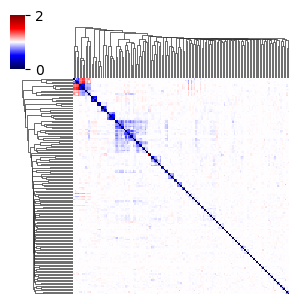

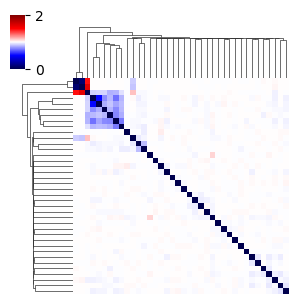

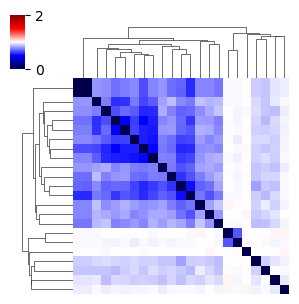

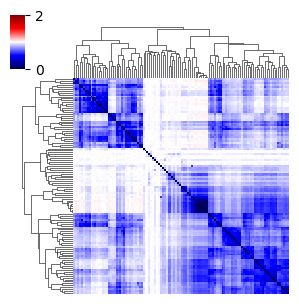

In [ ]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris

# sns.set(font="monospace")
for i, disease in enumerate(single_disease_examples):
    # dsaids w/ diseases of interest
    dsaids_interest = disease_2_dsaid_filtered.get(disease)

    # Extract the specific vectors using the list of indexes
    interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])
    data = matrix_cosine_distance[interest_idxs][:, interest_idxs]
    linkage = hc.linkage(data, method="average")

    # Create a cluster map
    g = sns.clustermap(
        data,
        row_linkage=linkage,
        col_linkage=linkage,
        cmap="seismic",
        vmin=0,  # Minimum value of the colormap
        vmax=2,  # Maximum value of the colormap
        figsize=(3, 3),
        row_cluster=True,  # Disable clustering for rows
        xticklabels=False,  # Remove x-axis tick labels
        yticklabels=False,  # Remove y-axis tick labels
        # dendrogram_ratio=(0, 0)  # Set dendrogram size to zero for both rows and columns
    )
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"cluster.{disease}.{metric_evaluated}.mesh.{sparsity}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
for i, disease in enumerate(single_disease_examples):
    # query
    QUERY = f"disease == @disease"
    dsaids = df_matrix.query(QUERY)["dsaid"].to_list()

    print(dsaids)

['DSA00073', 'DSA00074', 'DSA00247', 'DSA00248', 'DSA00249', 'DSA00250', 'DSA00459', 'DSA00460', 'DSA00627', 'DSA00628', 'DSA00717', 'DSA00825', 'DSA00826', 'DSA00827', 'DSA01175', 'DSA01176', 'DSA01230', 'DSA01231', 'DSA01344', 'DSA01521', 'DSA01522', 'DSA01539', 'DSA01540', 'DSA01541', 'DSA01542', 'DSA01651', 'DSA01664', 'DSA01665', 'DSA01755', 'DSA01929', 'DSA01930', 'DSA01960', 'DSA01961', 'DSA01962', 'DSA01963', 'DSA02060', 'DSA02248', 'DSA02249', 'DSA02595', 'DSA02596', 'DSA02603', 'DSA02604', 'DSA02638', 'DSA02639', 'DSA02640', 'DSA02641', 'DSA02642', 'DSA03496', 'DSA03497', 'DSA03624', 'DSA03743', 'DSA03746', 'DSA03747', 'DSA03748', 'DSA03749', 'DSA03750', 'DSA03751', 'DSA03752', 'DSA04061', 'DSA04062', 'DSA04460', 'DSA04507', 'DSA04508', 'DSA04644', 'DSA04684', 'DSA04685', 'DSA04706', 'DSA04811', 'DSA04812', 'DSA05038', 'DSA05040', 'DSA05041', 'DSA05069', 'DSA05077', 'DSA05080', 'DSA05111', 'DSA05392', 'DSA05393', 'DSA05394', 'DSA05395', 'DSA05397', 'DSA05411', 'DSA05412', 'DS

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    average_precision_score,
)
import numpy as np


def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3


def get_k_precision(idxs, k, matrix, top=True):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs (list): indexes
        k (int): k values
        matrix (np.array): matrix of similarities
        top (bool): get top k or bottom k
    Returns:
        np.array: precision values
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    if top:
        idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    else:
        idx_k = np.argpartition(matrix[idxs], k, axis=1)[:, :k]
    return list(np.sum(labels[idx_k], axis=1))


# Example AUROC calculation using kNN for each disease signature
auroc_scores = {"correlation": [], "cosine": [], "euclidean": [], "disease": []}
auroc_scores = {"correlation": [], "disease": []}

# Assuming `data_matrix` is your feature matrix where rows are disease signatures
num_diseases = len(most_common_diseases)

copy_matrix_pearson_correlation = np.copy(matrix_pearson_correlation)
np.fill_diagonal(copy_matrix_pearson_correlation, 0)

copy_matrix_cosine_distance = np.copy(matrix_cosine_distance)
np.fill_diagonal(copy_matrix_cosine_distance, 1)

copy_matrix_euclidean_distance = np.copy(matrix_euclidean_distance)
np.fill_diagonal(copy_matrix_euclidean_distance, np.inf)


correlation_tp_dict = dict()
cosine_tp_dict = dict()
euclidean_tp_dict = dict()

for idx, disease in tqdm(enumerate(single_disease_examples)):

    # dsaids w/ diseases of interest
    QUERY = f"disease == @disease"
    df_query = df_matrix.query(QUERY)
    dsaids_interest = df_query["dsaid"].to_list()
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    correlation_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_pearson_correlation
    )

    cosine_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_cosine_distance, top=False
    )

    euclidean_tp_dict[disease] = get_k_precision(
        interest_idxs, 3, copy_matrix_euclidean_distance, top=False
    )

del (
    copy_matrix_pearson_correlation,
    copy_matrix_cosine_distance,
    copy_matrix_euclidean_distance,
)

4it [00:00, 73.37it/s]


In [ ]:
for x in correlation_tp_dict.values():
    print(np.mean(x))

1.4
0.5526315789473685
1.434782608695652
2.642857142857143


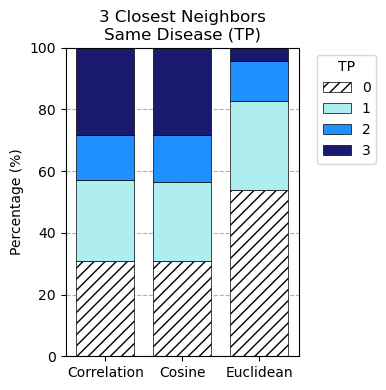

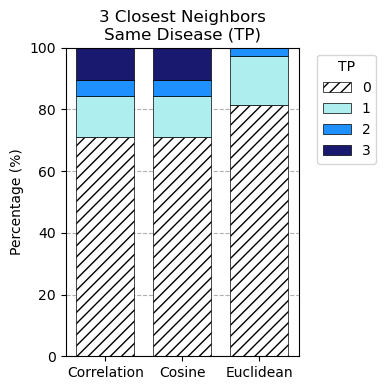

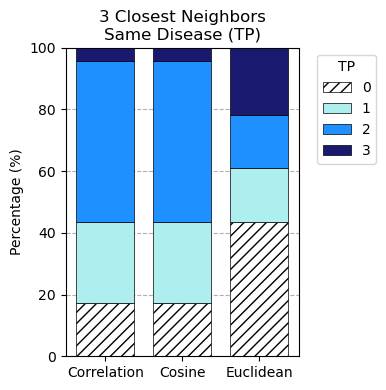

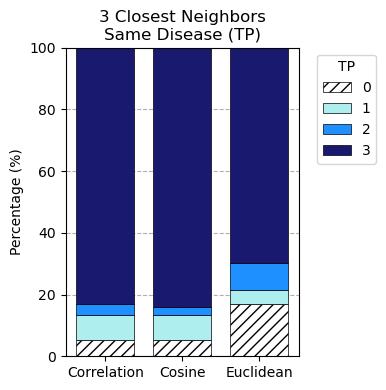

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for disease in single_disease_examples:

    # Simulated data for each metric (assuming integers 0, 1, 2, 3 represent the count of nearest neighbors that are the same disease)
    data_1 = correlation_tp_dict.get(disease)  # Correlation
    data_2 = cosine_tp_dict.get(disease)  # Cosine
    data_3 = euclidean_tp_dict.get(disease)  # Euclidean

    # Bin edges for the categories
    bins = np.array([0, 1, 2, 3, 4])

    # define colors
    colors = ["white", "paleturquoise", "#1E90FF", "midnightblue"]

    # Calculate histogram data for each
    counts_1, _ = np.histogram(data_1, bins=bins)
    counts_2, _ = np.histogram(data_2, bins=bins)
    counts_3, _ = np.histogram(data_3, bins=bins)

    # Labels for the plot
    metrics_labels = ["Correlation", "Cosine", "Euclidean"]
    category_labels = [f"{i}" for i in range(4)]  # Labels for the legend

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(4, 4))

    # Width of each stack segment
    width = 0.75

    # Convert counts to percentage
    percentage_1 = counts_1 / len(data_1) * 100
    percentage_2 = counts_2 / len(data_2) * 100
    percentage_3 = counts_3 / len(data_3) * 100

    # Stack the bars for each metric
    for i, counts in enumerate([percentage_1, percentage_2, percentage_3]):
        bottom_shift = np.cumsum([0] + counts.tolist())[
            :-1
        ]  # Calculate the bottom position for each stack
        for j in range(len(counts)):

            if j == 0:
                ax.bar(
                    metrics_labels[i],
                    counts[j],
                    bottom=bottom_shift[j],
                    width=width,
                    label=f"{category_labels[j]}" if i == 0 else "",
                    color=colors[j],
                    zorder=2,
                    edgecolor="black",
                    linewidth=0.5,
                    hatch="///",
                )
            else:
                ax.bar(
                    metrics_labels[i],
                    counts[j],
                    bottom=bottom_shift[j],
                    width=width,
                    label=f"{category_labels[j]}" if i == 0 else "",
                    color=colors[j],
                    zorder=2,
                    edgecolor="black",
                    linewidth=0.5,
                )

    # Add a legend and axis labels
    ax.set_ylabel("Percentage (%)")
    ax.set_title("3 Closest Neighbors\nSame Disease (TP)")
    ax.legend(title="TP", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.ylim(0, 100)
    # Show the plot
    plt.grid(linestyle="--", zorder=-3)
    plt.tight_layout()

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"nn.{disease}.{metric_evaluated}.mesh.{sparsity}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

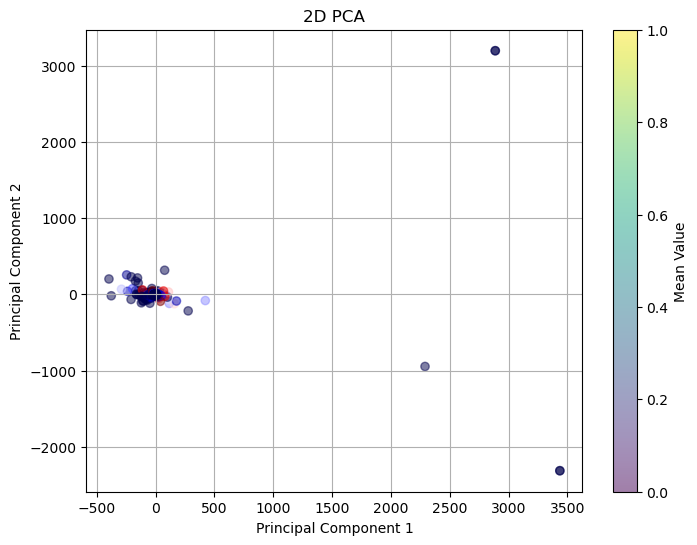

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_components = 64

# Create a colormap instance
cmap = plt.get_cmap("seismic")

# Standardize the dataset
scaler = StandardScaler()
data_matrix_standardized = scaler.fit_transform(data_matrix)

data_matrix_copy = data_matrix.copy()
data_matrix_standardized = data_matrix_copy
# Calculate the mean of each data point in the original data
means = np.mean(data_matrix_copy, axis=1)

# Perform PCA
pca = PCA(
    n_components=n_components
)  # Use 3 components for 3D visualization and explained variance plot
pca_result = pca.fit_transform(data_matrix_standardized)

# 2D PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c=cmap(means))
plt.title("2D PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Mean Value")  # Show color scale
plt.grid(True)
plt.show()

In [ ]:
dsaids_matrix[np.argmax(pca_result[:, 0])]

'DSA06646'

In [ ]:
np.argmax(pca_result[:, 0])

3403

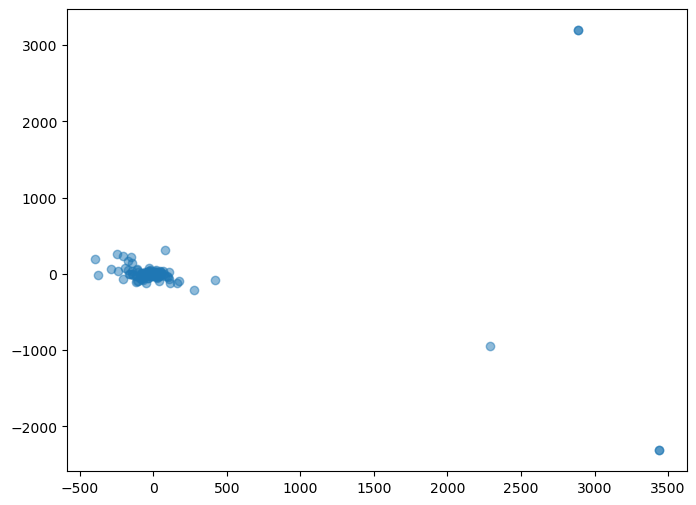

In [ ]:
pca = PCA(
    n_components=n_components
)  # Use 3 components for 3D visualization and explained variance plot
pca_result = pca.fit_transform(data_matrix)

# 2D PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

In [ ]:
pca.explained_variance_ratio_

array([0.06015927, 0.04164869, 0.03620209, 0.03208912, 0.02979153,
       0.02737147, 0.02685436, 0.02546957, 0.02245659, 0.02134226,
       0.0196198 , 0.01929425, 0.01855039, 0.01797448, 0.01753649,
       0.01689078, 0.0167692 , 0.01513808, 0.014962  , 0.01443106,
       0.0140357 , 0.01374714, 0.01294208, 0.0120575 , 0.0118499 ,
       0.01144981, 0.01061241, 0.00960253, 0.00940136, 0.00830169,
       0.00802813, 0.0076951 , 0.0066595 , 0.00636984, 0.00620825,
       0.00605295, 0.0058489 , 0.00566128, 0.00555019, 0.0053175 ,
       0.00528692, 0.0050611 , 0.0049956 , 0.00471062, 0.00463428,
       0.00455004, 0.00446061, 0.00435509, 0.00416278, 0.00408836,
       0.00399036, 0.00389104, 0.00382389, 0.0036437 , 0.00348254,
       0.00344264, 0.00341578, 0.00338015, 0.00331212, 0.00327016,
       0.00319311, 0.00315917, 0.00310991, 0.00296426])

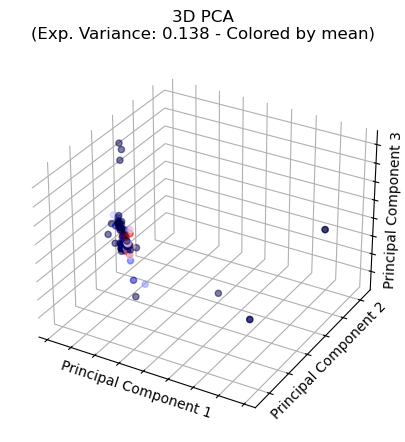

In [ ]:
# Create 3D PCA plot
fig = plt.figure(figsize=(7, 5))  # Increased figure size
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    alpha=0.5,
    c=cmap(means),
)

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Set edge color to white
ax.xaxis.pane.set_edgecolor("w")
ax.yaxis.pane.set_edgecolor("w")
ax.zaxis.pane.set_edgecolor("w")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

# Set labels
ax.set_xlabel("Principal Component 1", labelpad=-12)
ax.set_ylabel("Principal Component 2", labelpad=-12)
ax.set_zlabel("Principal Component 3", labelpad=-12)
ax.set_title(
    "3D PCA\n(Exp. Variance: %.3f - Colored by mean)"
    % pca.explained_variance_ratio_[:3].sum()
)
ax.tick_params(axis="z", pad=-3)


plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.3d_pca_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

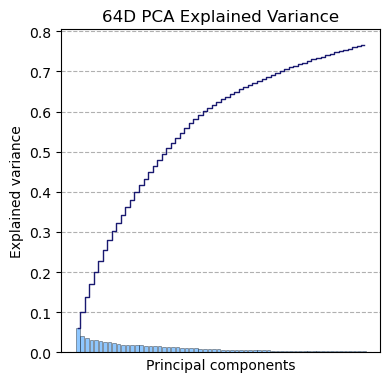

In [ ]:
# Explained variance plot
plt.figure(figsize=(4, 4))
plt.bar(
    range(1, n_components + 1),  # Adjust range to match the number of components
    pca.explained_variance_ratio_,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
    color="#1E90FF",
    edgecolor="black",
    linewidth=0.5,
)
plt.step(
    range(1, n_components + 1),  # Adjust range
    np.cumsum(pca.explained_variance_ratio_),
    where="mid",
    label="Cumulative",
    color="midnightblue",
    linewidth=1,
)
plt.ylabel("Explained variance")
plt.xlabel("Principal components")
# plt.legend(loc="best")
plt.tight_layout()
plt.xticks([])  # Ensure x-ticks for all components
plt.title("64D PCA Explained Variance")

plt.grid(True, zorder=-3, linestyle="--")
plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.variance_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

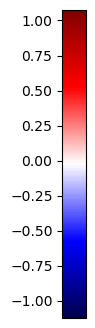

In [ ]:
# Create a figure for the color bar
fig, ax = plt.subplots(figsize=(0.3, 4))

# Create a scalar mappable for the color bar
norm = mpl.colors.Normalize(vmin=np.min(means), vmax=np.max(means))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can safely ignore this line as it's just to avoid warnings

# Create the color bar
cbar = plt.colorbar(sm, cax=ax)

# Move color bar tick labels and lines to the left
cbar.ax.yaxis.set_ticks_position("left")  # This moves tick lines to the left
cbar.ax.yaxis.set_label_position(
    "left"
)  # This ensures the label is aligned with the ticks
cbar.ax.yaxis.set_tick_params(
    labelleft=True, labelright=False
)  # Adjusts labels to the left

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"pca.cbar_{metric_evaluated}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


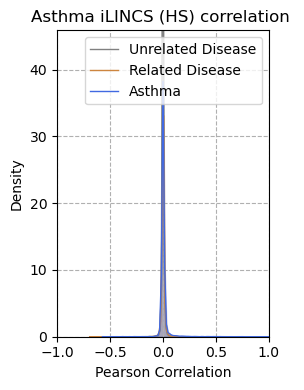

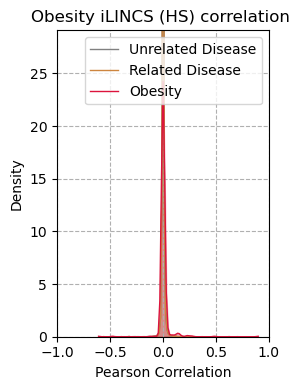

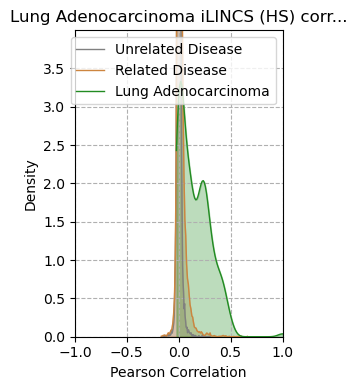

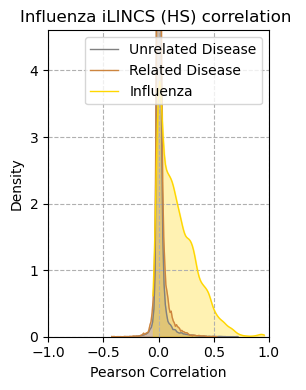

In [ ]:
# Plot distribution of means

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

single_disease_examples = [
    "Asthma",
    "Obesity",
    "Lung Adenocarcinoma",
    "Influenza",
]

# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]
colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# get index for diseases of interest

for i, disease in enumerate(tqdm(single_disease_examples)):
    # get index of the disease
    disease_index = most_common_diseases.index(disease)

    value_1 = correlation_values_interest_all[disease_index].flatten()
    value_2 = correlation_values_related_all[disease_index].flatten()
    value_3 = correlation_values_unrelated_all[disease_index].flatten()

    # Plot setup
    plt.figure(figsize=(3, 4))

    # Plot distribution for value_3
    density_3 = stats.gaussian_kde(value_3)
    x_3 = np.linspace(min(value_2), max(value_3), 100)
    plt.plot(x_3, density_3(x_3), linewidth=1, label="Unrelated Disease", color="grey")
    plt.fill_between(x_3, density_3(x_3), alpha=0.3, color="grey")

    # Plot distribution for value_2
    density_2 = stats.gaussian_kde(value_2)
    x_2 = np.linspace(min(value_2), max(value_2), 100)
    plt.plot(x_2, density_2(x_2), linewidth=1, label="Related Disease", color="peru")
    plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="peru")

    # Plot distribution for value_1
    density_1 = stats.gaussian_kde(value_1)
    x_1 = np.linspace(min(value_1), max(value_1), 100)
    plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
    plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

    # Finalizing plot
    title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
    title_example = (
        title_example[:36] + "..." if len(title_example) > 40 else title_example
    )

    plt.title(title_example)
    plt.legend()
    plt.xlabel("Pearson Correlation")
    plt.xlim(-1, 1)
    plt.ylim(0, max(density_1(x_1)) * 1.2)
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"distribution.mesh.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

In [ ]:
df_matrix[df_matrix["disease"] == "Asthma"]

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
72,DSA00073,GSE206510,GPL16791,2,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,5|5,DO:A bronchial disease that is characterized b...
73,DSA00074,GSE206510,GPL16791,1,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,4|5,DO:A bronchial disease that is characterized b...
246,DSA00247,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
247,DSA00248,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
248,DSA00249,GSE100624,GPL17303,1000,Asthma,C0004096,Peripheral blood,GEO,RNA-Seq,Homo sapiens,1|3,DO:A bronchial disease that is characterized b...
...,...,...,...,...,...,...,...,...,...,...,...,...
8868,DSA08869,GSE144576,GPL20301,954,Asthma,C0004096,NaN,GEO,RNA-Seq,Homo sapiens,8|8,DO:A bronchial disease that is characterized b...
9400,DSA09401,GSE147878,GPL10558,116,Asthma,C0004096,Bronchus,GEO,Microarray,Homo sapiens,13|18,DO:A bronchial disease that is characterized b...
9401,DSA09402,GSE147880,GPL6104,0,Asthma,C0004096,Sputum,GEO,Microarray,Homo sapiens,18|8,DO:A bronchial disease that is characterized b...
9411,DSA09412,GSE148004,GPL13497,0,Asthma,C0004096,Sputum,GEO,Microarray,Homo sapiens,9|9,DO:A bronchial disease that is characterized b...


In [ ]:
# # Corrected function name and variable names for clarity
# def get_top_k_library_strategies(disease, k=2, df_matrix=df_matrix):
#     """Get Top K Library Strategies for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#         df_matrix (DataFrame): DataFrame containing the data
#     Returns:
#         list: list of k most common library strategies
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k_strategies = df_filtered["library_strategy"].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_per_strategy = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k_strategies:
#         dsaids = df_filtered[df_filtered["library_strategy"] == strategy][
#             "dsaid"
#         ].tolist()
#         dsaids_per_strategy.append(dsaids)

#     return (top_k_strategies.tolist(), dsaids_per_strategy)


# def get_top_k_tissues(disease, k=4, df_matrix=df_matrix):
#     """Get Top K Tissues for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#     Returns
#         tissues (list): list of k most common tissues
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k_strategies = df_filtered["tissue"].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_per_strategy = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k_strategies:
#         dsaids = df_filtered[df_filtered["tissue"] == strategy]["dsaid"].tolist()
#         dsaids_per_strategy.append(dsaids)

#     return (top_k_strategies.tolist(), dsaids_per_strategy)


# # Assuming 'df_data_info_processed_filtered' is your DataFrame and you want to find top 4 library strategies for "Covid-19"
# top_k_library_strategies, dsaids_library_stratergies = get_top_k_library_strategies(
#     "COVID-19", 2, df_matrix
# )
# print(top_k_library_strategies)

# top_k_tissues, dsaids_tissues = get_top_k_tissues("COVID-19", 6, df_matrix)
# print(top_k_tissues)

# top_k_accessions, dsaids_accessions = get_top_k_accessions("COVID-19", 4, df_matrix)
# print(top_k_accessions)

In [ ]:
# def get_top_k(disease, field, k=4, df_matrix=df_matrix):
#     """Get Top K Tissues for a specific disease
#     Args:
#         disease (str): disease of interest
#         k (int): top k most common values
#     Returns
#         tissues (list): list of k most common tissues
#     """
#     # Filter DataFrame for the specified disease
#     df_filtered = df_matrix[df_matrix["disease"] == disease]

#     # Get the top k library strategies
#     top_k = df_filtered[field].value_counts().head(k).index

#     # Initialize list to store lists of DSAIDs for each library strategy
#     dsaids_interest = []

#     # Iterate through top k library strategies and collect corresponding DSAIDs
#     for strategy in top_k:
#         dsaids = df_filtered[df_filtered[field] == strategy]["dsaid"].tolist()
#         dsaids_interest.append(dsaids)

#     return (top_k.tolist(), dsaids_interest)

In [ ]:
# df_matrix[df_matrix["disease"] == "COVID-19"]["library_strategy"].value_counts()

In [ ]:
# top_k, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

In [ ]:
# # Tissue Bias
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import gaussian_kde

# disease = "COVID-19"
# k = 4
# field = "accession"
# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# plt.figure(figsize=(8, 8))
# scatter = plt.scatter(
#     embedded_data[:, 0],
#     embedded_data[:, 1],
#     c=density,
#     cmap="grey",
#     s=20,
#     edgecolor="none",
#     alpha=0.8,
# )


# # get specific tissues for disease
# top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

# for i, top_k in enumerate(top_ks):
#     # dsaids for specific tissue
#     dsaids_interest = top_k_dsaids[i]

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     if field == "accession":
#         label_text = f"{disease}: Dataset {i+1} ({len(interest_idxs)})"

#     else:
#         label_text = f"{disease}: {top_k}"

#     plt.scatter(
#         embedded_data[interest_idxs, 0],
#         embedded_data[interest_idxs, 1],
#         color=colors[i],
#         label=label_text,
#         s=40,
#         alpha=0.8,
#     )

# plt.legend()
# # plt.colorbar(scatter, label="Local Density")
# plt.title(f"t-SNE {disease} {field} ( {metric_evaluated} {sparsity} Signatures )")
# # plt.xlabel("t-SNE Dimension 1")
# # plt.ylabel("t-SNE Dimension 2")
# plt.xticks([])
# plt.yticks([])

# plt.savefig(
#     os.path.join(
#         "..",
#         "results",
#         "figures",
#         "DiSignAtlas",
#         f"tsne.{disease}.{field}.{sparsity}.{metric_evaluated}.png",
#     ),
#     dpi=300,
#     bbox_inches="tight",
# )

In [ ]:
# # Plot distribution of means

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# disease = "COVID-19"
# k = 4
# field = "accession"
# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# # get specific tissues for disease
# top_ks, top_k_dsaids = get_top_k(disease=disease, field=field, k=k, df_matrix=df_matrix)

# for i, top_k in enumerate(top_ks):
#     # dsaids for specific tissue
#     dsaids_interest = top_k_dsaids[i]

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     # random indexes withtout replacement - appear once
#     random_rest_indexes = get_rest_indexes(
#         interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
#     )

#     # matrix interest
#     matrix_interest = data_matrix[interest_idxs]

#     # matrix rest
#     matrix_rest = data_matrix[random_rest_indexes]

#     # compute correlation
#     correlation_values_interest = compute_pearson_correlation(matrix_interest)
#     correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

#     value_1 = correlation_values_interest
#     value_2 = correlation_values_rest

#     # Plot setup
#     plt.figure(figsize=(4, 4))

#     # Plot distribution for value_1
#     density_1 = stats.gaussian_kde(value_1)
#     x_1 = np.linspace(min(value_1), max(value_1), 100)
#     plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
#     plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

#     # Plot distribution for value_2
#     density_2 = stats.gaussian_kde(value_2)
#     x_2 = np.linspace(min(value_2), max(value_2), 100)
#     plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
#     plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

#     # Finalizing plot
#     if field == "accession":
#         title_example = (
#             f"{disease} Dataset {i+1} {metric_evaluated} ({sparsity}) correlation"
#         )
#     else:
#         title_example = (
#             f"{disease} {top_k} {metric_evaluated} ({sparsity}) correlation "
#         )

#     title_example = (
#         title_example[:36] + "..." if len(title_example) > 40 else title_example
#     )

#     plt.title(title_example)
#     plt.legend()
#     plt.xlabel("Pearson Correlation")
#     plt.xlim(-1, 1)
#     plt.ylim(0, max(density_1(x_1)) * 1.2)
#     plt.ylabel("Density")
#     plt.grid(linestyle="--")
#     plt.tight_layout()

#     # save
#     plt.savefig(
#         os.path.join(
#             "..",
#             "results",
#             "figures",
#             "DiSignAtlas",
#             f"distribution.diseases_correlation.{disease}.{field}.{i}.{sparsity}.{metric_evaluated}.{disease}.png",
#         ),
#         dpi=300,
#         bbox_inches="tight",
#     )

In [ ]:
# # Plot distribution of means

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats

# single_disease_examples = [
#     "Colon Cancer",
# ]

# colors = ["#4169E1", "#DC143C", "#228B22", "#FFD700"]

# for i, disease in enumerate(tqdm(single_disease_examples)):

#     # dsaids w/ diseases of interest
#     dsaids_interest = disease_2_dsaid_filtered.get(disease)

#     # Extract the specific vectors using the list of indexes
#     interest_idxs = np.array([dsaids_matrix.index(d) for d in dsaids_interest])

#     # random indexes withtout replacement - appear once
#     random_rest_indexes = get_rest_indexes(
#         interest_idxs=interest_idxs, all_indexes=all_indexes, proportion=50
#     )

#     # matrix interest
#     matrix_interest = data_matrix[interest_idxs]

#     # matrix rest
#     matrix_rest = data_matrix[random_rest_indexes]

#     # compute correlation
#     correlation_values_interest = compute_pearson_correlation(matrix_interest)
#     correlation_values_rest = compute_pearson_correlation(matrix_interest, matrix_rest)

#     value_1 = correlation_values_interest
#     value_2 = correlation_values_rest

#     # Plot setup
#     plt.figure(figsize=(4, 4))

#     # Plot distribution for value_1
#     density_1 = stats.gaussian_kde(value_1)
#     x_1 = np.linspace(min(value_1), max(value_1), 100)
#     plt.plot(x_1, density_1(x_1), linewidth=1, label=f"{disease}", color=colors[i])
#     plt.fill_between(x_1, density_1(x_1), alpha=0.3, color=colors[i])

#     # Plot distribution for value_2
#     density_2 = stats.gaussian_kde(value_2)
#     x_2 = np.linspace(min(value_2), max(value_2), 100)
#     plt.plot(x_2, density_2(x_2), linewidth=1, label="Other Disease", color="grey")
#     plt.fill_between(x_2, density_2(x_2), alpha=0.3, color="grey")

#     # Finalizing plot
#     title_example = f"{disease} {metric_evaluated} ({sparsity}) correlation "
#     title_example = (
#         title_example[:36] + "..." if len(title_example) > 40 else title_example
#     )

#     plt.title(title_example)
#     plt.legend()
#     plt.xlabel("Pearson Correlation")
#     plt.xlim(-1, 1)
#     plt.ylim(0, max(density_1(x_1)) * 1.2)
#     plt.ylabel("Density")
#     plt.grid(linestyle="--")
#     plt.tight_layout()

#     # save
#     plt.savefig(
#         os.path.join(
#             "..",
#             "results",
#             "figures",
#             "DiSignAtlas",
#             f"distribution.diseases_correlation.{sparsity}.{metric_evaluated}.{disease}.png",
#         ),
#         dpi=300,
#         bbox_inches="tight",
#     )

### Plots MeSH Terms

#### Get diseases of interest

In [ ]:
# get diseases for the lowest mesh level we will compare ! ! !
# variables
lowest_mesh_level = 5
count_diseases_per_level = dict()
for level in [1, 2, 3, 4, 5]:
    diseases_of_interest = list()
    for count, disease in enumerate(tqdm(most_common_diseases)):

        # dsaids w/ diseases of interest
        QUERY = f"disease == @disease"
        df_query = df_matrix.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()

        # get mesh terms
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )

        if check_mesh_level(_dsaids_interest_mesh_terms, level=level):

            # get ids of rest
            _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

            related_dsaids = list()
            unrelated_dsaids = list()

            # classify rest of ids into related or unrelated
            for dsaid in _rest_dsaids:
                dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
                dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
                # check if they are related
                if check_common_mesh_terms(
                    list_1=_dsaids_interest_mesh_terms,
                    list_2=dsaid_mesh_terms,
                    level=level,
                ):
                    related_dsaids.append(dsaid)

                else:
                    unrelated_dsaids.append(dsaid)

            if len(related_dsaids) > 10:
                diseases_of_interest.append(disease)

    count_diseases_per_level[level] = len(diseases_of_interest)
logging.info(f"Nº of diseases {len(diseases_of_interest)}")

100%|██████████| 209/209 [00:02<00:00, 103.75it/s]
2024-05-08 13:19:20,536 - INFO - Nº of diseases 62


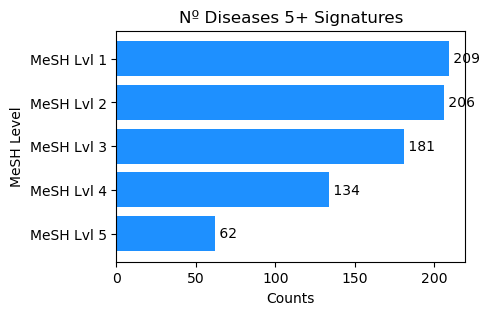

In [ ]:
def plot_horizontal_bar(data):
    # Extract keys and values from the dictionary
    labels = [f"MeSH Lvl {key}" for key in [5, 4, 3, 2, 1]]
    values = [data.get(key) for key in [5, 4, 3, 2, 1]]

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(4.5, 3))

    # Plot horizontal bar plot
    ax.barh(labels, values, color="#1E90FF")  # You can change the color if needed

    # Set title and labels
    ax.set_title("Nº Diseases 5+ Signatures")
    ax.set_xlabel("Counts")
    ax.set_ylabel("MeSH Level")

    # Optional: Add value labels on bars
    for index, value in enumerate(values):
        ax.text(value, index, f" {value}", va="center", ha="left")

    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"counts_diseases.mesh_all.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )


plot_horizontal_bar(data=count_diseases_per_level)

In [ ]:
count_diseases_per_level

{1: 209, 2: 206, 3: 181, 4: 134, 5: 62}

#### Compute Similarities

In [ ]:
d_mesh_correlation = dict()
d_mesh_cosine = dict()
d_mesh_euclidean = dict()

# variables
k_top = 1
k_percent = 0.2
mesh_level = 5
bootstrap = True
n_diseases = 0

d_n_signatures = dict()


for mesh_level in [1, 2, 3, 4, 5]:

    d_n_signatures[mesh_level] = dict()
    d_n_signatures[mesh_level]["interest"] = list()
    d_n_signatures[mesh_level]["related"] = list()

    correlation_values_interest_all = list()
    correlation_values_related_all = list()
    correlation_values_unrelated_all = list()

    cosine_values_interest_all = list()
    cosine_values_related_all = list()
    cosine_values_unrelated_all = list()

    euclidean_values_interest_all = list()
    euclidean_values_related_all = list()
    euclidean_values_unrelated_all = list()

    # get values
    all_indexes = set(range(data_matrix.shape[0]))

    for count, disease in enumerate(tqdm(diseases_of_interest)):

        # dsaids w/ diseases of interest
        QUERY = f"disease == @disease"
        df_query = df_matrix.query(QUERY)
        dsaids_interest = df_query["dsaid"].to_list()

        d_n_signatures[mesh_level]["interest"].append(len(dsaids_interest))
        related_dsaids = list()
        unrelated_dsaids = list()

        # get mesh terms
        _dsaids_interest_mesh_terms = list(
            {
                mesh_term
                for d in dsaids_interest
                for mesh_term in dsaids_2_mesh_tree_terms.get(d, [])
            }
        )

        if check_mesh_level(_dsaids_interest_mesh_terms, level=mesh_level):

            # Extract the specific vectors using the list of indexes
            interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

            # interest indexes pairs
            """We have a list of lists in which we have
            for each disease signature of interest (row of a matrix) a list in which 
            we will have all the combination of pairs"""

            n_interest = len(interest_idxs)

            # compute how many pairs we will have
            n_interest_unique = int(n_interest * (n_interest - 1) / 2)
            n_interest_all = int(n_interest * n_interest)

            interest_idxs_pairs = np.empty((n_interest, n_interest - 1, 2), dtype=int)
            interest_idxs_pairs_unique = np.empty((n_interest_unique, 2), dtype=int)

            # generate pairs (all vs all)
            matrix_interest_idxs_pairs = generate_matrix_idxs(
                interest_idxs, bootstrap=False
            )

            # define matrix to store values
            matrix_correlation_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            matrix_cosine_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            matrix_euclidean_values_interest = np.empty(
                (n_interest, n_interest - 1), dtype=float
            )

            # itereate through all interest signatures
            for i, row_interest in enumerate(matrix_interest_idxs_pairs):
                # get values
                correlation_values_interest = matrix_pearson_correlation[
                    row_interest[:, 0], row_interest[:, 1]
                ]
                cosine_values_interest = matrix_cosine_distance[
                    row_interest[:, 0], row_interest[:, 1]
                ]
                euclidean_values_interest = matrix_euclidean_distance[
                    row_interest[:, 0], row_interest[:, 1]
                ]

                # store values
                matrix_correlation_values_interest[i] = correlation_values_interest
                matrix_cosine_values_interest[i] = cosine_values_interest
                matrix_euclidean_values_interest[i] = euclidean_values_interest

            # get rest indexes
            # get ids of rest
            _rest_dsaids = list(set(dsaids_matrix) - set(dsaids_interest))

            # classify rest of ids into related or unrelated
            for dsaid in _rest_dsaids:
                dsaid_mesh_terms = dsaids_2_mesh_tree_terms.get(dsaid, [])
                dsaid_mesh_terms = [d for d in dsaid_mesh_terms]
                # check if they are related
                if check_common_mesh_terms(
                    list_1=_dsaids_interest_mesh_terms,
                    list_2=dsaid_mesh_terms,
                    level=mesh_level,
                ):
                    related_dsaids.append(dsaid)

                else:
                    unrelated_dsaids.append(dsaid)
            if len(related_dsaids) > 0:
                n_diseases += 1
                # get idx position related and unrelated
                related_idxs = [dsaids_matrix.index(d) for d in related_dsaids]
                unrelated_idxs = [dsaids_matrix.index(d) for d in unrelated_dsaids]

                d_n_signatures[mesh_level]["related"].append(len(related_idxs))

                # get nº
                n_related = len(related_idxs)
                n_unrelated = len(unrelated_idxs)

                # generate matrix indexes pairs
                matrix_related_idxs_pairs = generate_matrix_idxs(
                    interest_idxs, related_idxs, bootstrap=bootstrap
                )
                matrix_unrelated_idxs_pairs = generate_matrix_idxs(
                    interest_idxs, unrelated_idxs, bootstrap=bootstrap
                )

                # define matrix to store values
                n_columns = (n_interest) * 100 if bootstrap else n_related
                matrix_correlation_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_cosine_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_euclidean_values_related = np.empty(
                    (n_interest, n_columns), dtype=float
                )

                # iterate through all interest signature pairs
                for idx, row_related in enumerate(matrix_related_idxs_pairs):

                    # get values
                    correlation_values_related = matrix_pearson_correlation[
                        row_related[:, 0], row_related[:, 1]
                    ]
                    cosine_values_related = matrix_cosine_distance[
                        row_related[:, 0], row_related[:, 1]
                    ]
                    euclidean_values_related = matrix_euclidean_distance[
                        row_related[:, 0], row_related[:, 1]
                    ]

                    # store values
                    matrix_correlation_values_related[idx] = correlation_values_related
                    matrix_cosine_values_related[idx] = cosine_values_related
                    matrix_euclidean_values_related[idx] = euclidean_values_related

                # define matrix to store values
                n_columns = (n_interest) * 100 if bootstrap else n_unrelated
                matrix_correlation_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_cosine_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )
                matrix_euclidean_values_unrelated = np.empty(
                    (n_interest, n_columns), dtype=float
                )

                # iterate through all interest signature pairs to find top closest
                for idx, row_unrelated in enumerate(matrix_unrelated_idxs_pairs):

                    # get correlation values
                    correlation_values_unrelated = matrix_pearson_correlation[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]
                    cosine_values_unrelated = matrix_cosine_distance[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]
                    euclidean_values_unrelated = matrix_euclidean_distance[
                        row_unrelated[:, 0], row_unrelated[:, 1]
                    ]

                    # get matrix to store values
                    matrix_correlation_values_unrelated[idx] = (
                        correlation_values_unrelated
                    )
                    matrix_cosine_values_unrelated[idx] = cosine_values_unrelated
                    matrix_euclidean_values_unrelated[idx] = euclidean_values_unrelated

                # store all computed values
                correlation_values_interest_all.append(
                    matrix_correlation_values_interest
                )
                correlation_values_related_all.append(matrix_correlation_values_related)
                correlation_values_unrelated_all.append(
                    matrix_correlation_values_unrelated
                )

                cosine_values_interest_all.append(matrix_cosine_values_interest)
                cosine_values_related_all.append(matrix_cosine_values_related)
                cosine_values_unrelated_all.append(matrix_cosine_values_unrelated)

                euclidean_values_interest_all.append(matrix_euclidean_values_interest)
                euclidean_values_related_all.append(matrix_euclidean_values_related)
                euclidean_values_unrelated_all.append(matrix_euclidean_values_unrelated)

    assert (
        len(diseases_of_interest)
        == len(correlation_values_interest_all)
        == len(correlation_values_unrelated_all)
    ), "Err something wrong with the length of the lists"

    logging.info(f"Nº diseases evaluated {n_diseases}")

    # save values
    d_mesh_correlation[mesh_level] = dict()
    d_mesh_correlation[mesh_level]["interest"] = correlation_values_interest_all
    d_mesh_correlation[mesh_level]["related"] = correlation_values_related_all
    d_mesh_correlation[mesh_level]["unrelated"] = correlation_values_unrelated_all

    d_mesh_cosine[mesh_level] = dict()
    d_mesh_cosine[mesh_level]["interest"] = cosine_values_interest_all
    d_mesh_cosine[mesh_level]["related"] = cosine_values_related_all
    d_mesh_cosine[mesh_level]["unrelated"] = cosine_values_unrelated_all

    d_mesh_euclidean[mesh_level] = dict()
    d_mesh_euclidean[mesh_level]["interest"] = euclidean_values_interest_all
    d_mesh_euclidean[mesh_level]["related"] = euclidean_values_related_all
    d_mesh_euclidean[mesh_level]["unrelated"] = euclidean_values_unrelated_all

100%|██████████| 62/62 [00:10<00:00,  6.17it/s]
2024-05-08 13:19:33,278 - INFO - Nº diseases evaluated 62
100%|██████████| 62/62 [00:10<00:00,  6.14it/s]
2024-05-08 13:19:43,377 - INFO - Nº diseases evaluated 124
100%|██████████| 62/62 [00:10<00:00,  6.12it/s]
2024-05-08 13:19:53,507 - INFO - Nº diseases evaluated 186
100%|██████████| 62/62 [00:10<00:00,  6.13it/s]
2024-05-08 13:20:03,620 - INFO - Nº diseases evaluated 248
100%|██████████| 62/62 [00:10<00:00,  6.17it/s]
2024-05-08 13:20:13,668 - INFO - Nº diseases evaluated 310


In [ ]:
def plot_boxplots(data=d_n_signatures):
    # Assume we are working with a specific key or adjust to loop over keys if needed

    # Extract each category of data from the dictionary
    interest = data[1].get("interest", [])
    related1 = data[1].get("related", [])
    related2 = data[2].get("related", [])
    related3 = data[3].get("related", [])
    related4 = data[4].get("related", [])
    related5 = data[5].get("related", [])

    # Data for plotting - using lists directly which can have different lengths
    plot_data = [related5, related4, related3, related2, related1, interest]
    labels = ["MeSH 5", "MeSH 4", "MeSH 3", "MeSH 2", "MeSH 1", "Same"]
    colors = [
        "#D3D3D3",
        "#088F8F",
        "#50C878",
        "#AFEAAA",
        "#ECFFDC",
    ]
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(4, 9))

    # Plot violin plot with specified colors
    parts = ax.violinplot(plot_data, showmeans=True, showmedians=True, vert=False)

    # Color each part of the violin plot
    for partname, part in parts.items():
        if partname == "bodies":  # The main body of the violin plot
            for pc, color in zip(part, colors):
                pc.set_facecolor(color)
                pc.set_edgecolor("black")  # You can change the edge color if needed
                pc.set_alpha(1)  # Adjust transparency if desired

    # Customizing x-tick labels to match the data categories
    # ax.set_xticks([1, 2, 3, 4])
    # ax.set_xticklabels(labels)

    # Set title and labels
    ax.set_title("Comparison of Interest and Related Categories")
    ax.set_ylabel("Values")

    # Display the plot
    plt.show()

In [ ]:
def plot_boxplots(data):
    # Extract each category of data from the dictionary
    interest = data[1].get("interest", [])
    related1 = data[1].get("related", [])
    related2 = data[2].get("related", [])
    related3 = data[3].get("related", [])
    related4 = data[4].get("related", [])
    related5 = data[5].get("related", [])

    # Data for plotting - using lists directly which can have different lengths
    plot_data = [related5, related4, related3, related2, related1, interest]
    labels = [
        "Related MeSH 5",
        "Related MeSH 4",
        "Related MeSH 3",
        "Related MeSH 2",
        "Related MeSH 1",
        "Same",
    ]
    colors = ["#DFFF00", "#98FB98", "#AFEAAA", "#50C878", "#088F8F", "#D3D3D3"]

    # Create a figure and axis object with a specified figure size
    fig, ax = plt.subplots(figsize=(3, 6))

    # Plot horizontal violin plot with specified colors
    parts = ax.violinplot(plot_data, showmeans=False, showmedians=True, vert=False)

    # Color each part of the violin plot
    for partname, part in parts.items():
        if partname == "bodies":  # The main body of the violin plot
            for pc, color in zip(part, colors):
                pc.set_facecolor(color)
                pc.set_edgecolor("black")
                pc.set_alpha(1)

    # Customizing y-tick labels to match the data categories
    ax.set_yticks(range(1, len(labels) + 1))
    ax.set_yticklabels(labels)

    # Set title and labels
    ax.set_title("Nº of Signatures")
    ax.set_xlabel("Values")

    # Display the plot
    plt.savefig(
        os.path.join(
            "..",
            "results",
            "figures",
            "DiSignAtlas",
            f"mesh_levels.n_signatures.png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

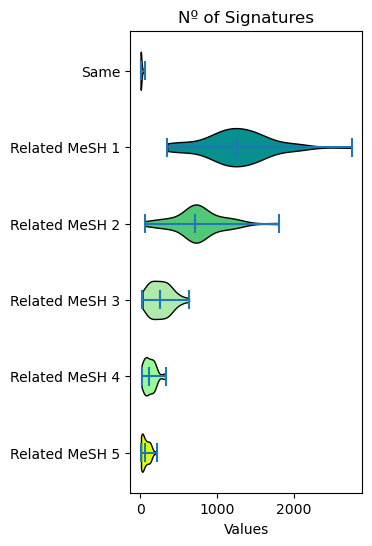

In [ ]:
plot_boxplots(data=d_n_signatures)

#### Plots

In [ ]:
# functions
def plot_metrics(
    values_list,
    ks_values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
    values_per_disease=True,
):

    # define variables

    colors = {0: "darkgrey", 1: "#088F8F", 2: "#AFEAAA", 3: "#DFFF00"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1.01, 0.05),
        "cosine": np.arange(0, 2.01, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }
    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        alpha = 0.5
        if i == 0:
            alpha = 1

        # compute normalized density counts for each distribution
        if values_per_disease:
            # compute normalized density counts for each distribution
            counts = create_composite_histogram(values, fixed_bins)
        else:
            counts, _ = np.histogram(values, bins=fixed_bins)
            counts = counts / len(values)

        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt
    # Formatting each p-value mean and std, and constructing parts of the title

    formatted_parts = [format_p_value_std(mean, std) for mean, std in ks_values_list]

    # Constructing the full title
    title = (
        "Same-MeSH 1 KS p-value: {}\n"
        "Same-MeSH 3 KS p-value: {}\n"
        "Same-MeSH 5 KS p-value: {}"
    ).format(*formatted_parts)

    plt.title(title, fontsize=10)

    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.mesh_levels.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

In [ ]:
def flatten(list_of_lists):
    """Flatten a list of lists into a single list."""
    return [item for sublist in list_of_lists for item in sublist]


def format_p_value(p):
    """Format the p-value in scientific notation if very small, else normal floating point notation."""
    return f"{p:.4e}" if p < 0.0001 else f"{p:.4f}"


# functions
def plot_global_metrics(
    values_list,
    labels,
    vector_type,
    metric_list,
    cap_value=None,
    save=True,
    sparsity="HS",
    modify_values=None,
):

    _values_list = list()
    for i, values in enumerate(values_list):
        if i == 0:
            if modify_values == "mean":
                _values_list.append([np.mean(x) for x in values])

            if modify_values == "min":
                _values_list.append([np.min(x) for x in values])

            if modify_values == "max":
                _values_list.append([np.max(x) for x in values])
        else:
            for matrix in values:
                values_disease = list()
                for sample_matrix in np.array_split(matrix[i, :], 100):
                    if modify_values == "mean":
                        values_disease.append(np.mean(sample_matrix))
                    if modify_values == "min":
                        values_disease.append(np.min(sample_matrix))
                    if modify_values == "max":
                        values_disease.append(np.max(sample_matrix))
            _values_list.append(values_disease)
    # re-define values list
    values_list = _values_list

    # define variables
    colors = {0: "#D3D3D3", 1: "#088F8F", 2: "#AFEAAA", 3: "#DFFF00"}
    metric, filtering = metric_list
    title_txt = f"{metric} {filtering} {vector_type} "
    e_max = 10
    e_step = 0.5
    if cap_value is not None:
        title_txt = f"{metric} {filtering} {vector_type} (capped)"
        e_max = cap_value
        e_step = cap_value / 100
    fixed_bins_dict = {
        "p_correlation": np.arange(-1, 1, 0.05),
        "cosine": np.arange(0, 2, 0.05),
        "euclidean": np.arange(0, e_max, e_step),
    }

    if modify_values is not None:
        ks_p_values_1_mean = ks_2samp(values_list[0], values_list[1])[1]
        ks_p_values_2_mean = ks_2samp(values_list[0], values_list[2])[1]
        ks_p_values_3_mean = ks_2samp(values_list[0], values_list[3])[1]

    ks_values_list = [ks_p_values_1_mean, ks_p_values_2_mean, ks_p_values_3_mean]

    fixed_bins = fixed_bins_dict.get(metric)
    print(metric)
    print(fixed_bins)
    plt.figure(figsize=(4.5, 3))

    # loop through values
    for i in range(len(values_list)):
        # define values
        values = values_list[i]
        label = labels[i]
        color = colors[i]

        if i == 0:
            alpha = 1
            counts, _ = np.histogram(values, bins=fixed_bins)
        else:
            alpha = 0.5
            print(values)
            # counts = create_composite_histogram(values, fixed_bins, is_list=True)
            counts, _ = np.histogram(values, bins=fixed_bins)
            # counts = counts / 100
        bin_centers = 0.5 * (fixed_bins[1:] + fixed_bins[:-1])
        print(len(counts))

        # Spline Interpolation for connecting midpoints
        spline = make_interp_spline(bin_centers, counts, k=1)  # k=3 for cubic spline
        fine_bin_centers = np.linspace(bin_centers.min(), bin_centers.max(), 300)
        fine_counts = spline(fine_bin_centers)

        # Plot interpolated line
        plt.plot(
            fine_bin_centers,
            fine_counts,
            color=color,
            label=label,
            linewidth=2.5,
        )
        plt.fill_between(fine_bin_centers, fine_counts, alpha=alpha, color=color)

    title_txt = title_txt[:35] + "..." if len(title_txt) > 40 else title_txt

    formatted_p_values = [format_p_value(p) for p in ks_values_list]

    # Constructing the title with formatted p-values
    title = (
        "Same-MeSH 1 KS p-value: {}\n"
        "Same-MeSH 3 KS p-value: {}\n"
        "Same-MeSH 5 KS p-value: {}"
    ).format(*formatted_p_values)

    plt.title(
        title,
        fontsize=10,
    )
    plt.suptitle(title_txt, y=0.95)
    plt.legend()
    plt.xlabel(f"{vector_type} {metric} {filtering}")
    plt.xlim(np.min(fixed_bins), np.max(fixed_bins))
    plt.ylim(
        0,
    )
    plt.ylabel("Density")
    plt.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(
            os.path.join(
                "..",
                "results",
                "figures",
                "DiSignAtlas",
                f"{metric}{filtering}.{modify_values}.mesh_levels.{sparsity}.{vector_type}.png",
            ),
            dpi=300,
            bbox_inches="tight",
        )

##### Plot Pearson Correlation

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


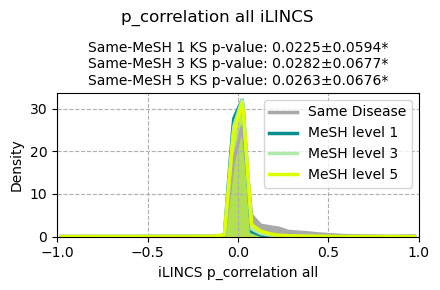

In [ ]:
# all


value_i = d_mesh_correlation[1]["interest"]

value_1 = d_mesh_correlation[1]["related"]

value_2 = d_mesh_correlation[3]["related"]

value_3 = d_mesh_correlation[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)

ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "all"],
    save=True,
)

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


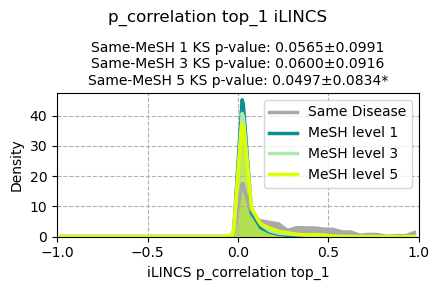

In [ ]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_correlation[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=False)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_correlation[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_correlation[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_correlation[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_1"],
    save=True,
)

p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


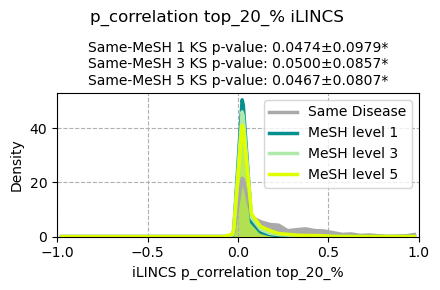

In [ ]:
# top k

top_k = 0.2

value_i = list()
for matrix in d_mesh_correlation[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_correlation[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_correlation[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_correlation[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["p_correlation", "top_20_%"],
    save=True,
)

2024-05-08 13:21:13,453 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-05-08 13:21:14,814 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


2024-05-08 13:21:16,122 - INFO - Nº of values: 100 100


p_correlation
[-1.0000000e+00 -9.5000000e-01 -9.0000000e-01 -8.5000000e-01
 -8.0000000e-01 -7.5000000e-01 -7.0000000e-01 -6.5000000e-01
 -6.0000000e-01 -5.5000000e-01 -5.0000000e-01 -4.5000000e-01
 -4.0000000e-01 -3.5000000e-01 -3.0000000e-01 -2.5000000e-01
 -2.0000000e-01 -1.5000000e-01 -1.0000000e-01 -5.0000000e-02
  8.8817842e-16  5.0000000e-02  1.0000000e-01  1.5000000e-01
  2.0000000e-01  2.5000000e-01  3.0000000e-01  3.5000000e-01
  4.0000000e-01  4.5000000e-01  5.0000000e-01  5.5000000e-01
  6.0000000e-01  6.5000000e-01  7.0000000e-01  7.5000000e-01
  8.0000000e-01  8.5000000e-01  9.0000000e-01  9.5000000e-01
  1.0000000e+00]


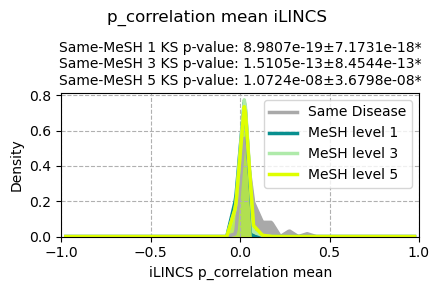

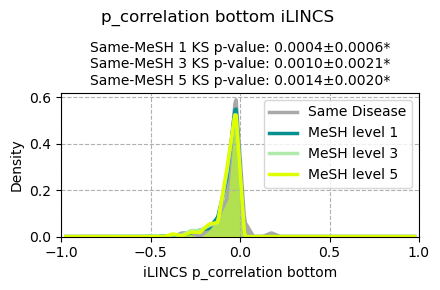

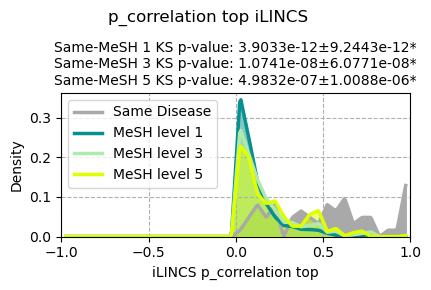

In [ ]:
# mean max min
operation_d = {"mean": np.mean, "bottom": np.min, "top": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [
        operation(matrix.flatten()) for matrix in d_mesh_correlation[1]["interest"]
    ]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_correlation[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["p_correlation", operation_type],
        values_per_disease=False,
        save=True,
    )

##### Euclidean

In [ ]:
# define values
step = 25
cap_val = (
    500
    if 500 < np.max(matrix_euclidean_distance)
    else np.max(matrix_euclidean_distance) + 1
)


# Function to cap values at a specific limit
def cap_values_at_limit(values, limit):
    return np.where(values > limit, limit, values)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


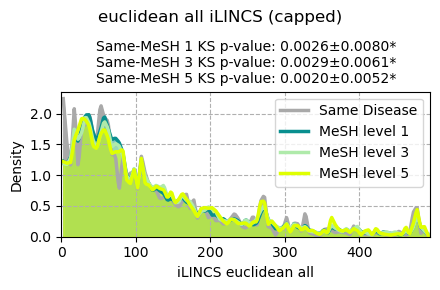

In [ ]:
# all

value_i = d_mesh_euclidean[1]["interest"]
value_1 = d_mesh_euclidean[1]["related"]
value_2 = d_mesh_euclidean[3]["related"]
value_3 = d_mesh_euclidean[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "all"],
    save=True,
    cap_value=cap_val,
)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


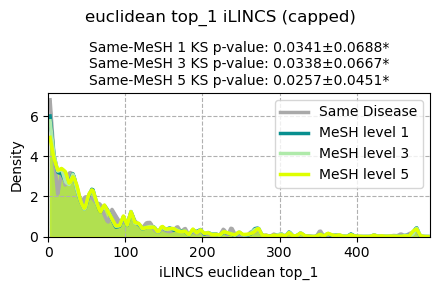

In [ ]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_euclidean[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_euclidean[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_euclidean[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_euclidean[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_1"],
    save=True,
    cap_value=cap_val,
)

euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


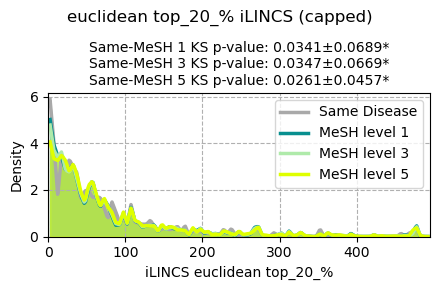

In [ ]:
# top k %

top_k = 0.2

value_i = list()
for matrix in d_mesh_euclidean[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_euclidean[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_euclidean[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_euclidean[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["euclidean", "top_20_%"],
    save=True,
    cap_value=cap_val,
)

2024-05-08 13:22:26,385 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-05-08 13:22:27,812 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


2024-05-08 13:22:29,175 - INFO - Nº of values: 100 100


euclidean
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300. 305. 310. 315. 320. 325. 330. 335. 340. 345.
 350. 355. 360. 365. 370. 375. 380. 385. 390. 395. 400. 405. 410. 415.
 420. 425. 430. 435. 440. 445. 450. 455. 460. 465. 470. 475. 480. 485.
 490. 495.]


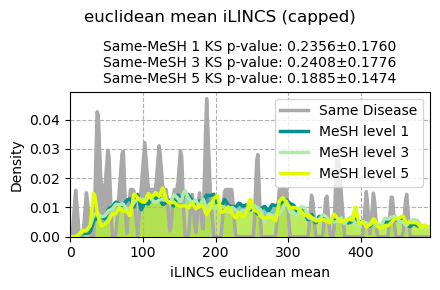

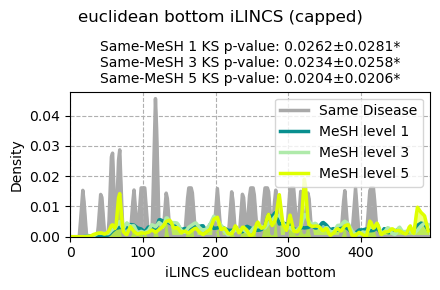

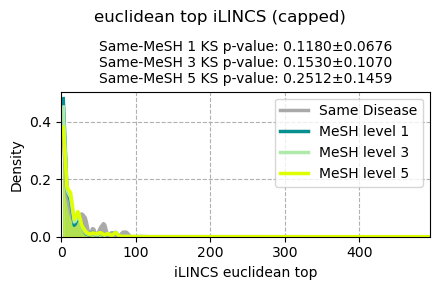

In [ ]:
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [
        operation(matrix.flatten()) for matrix in d_mesh_euclidean[1]["interest"]
    ]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_euclidean[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["euclidean", operation_type],
        values_per_disease=False,
        cap_value=cap_val,
        save=True,
    )

##### Cosine

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


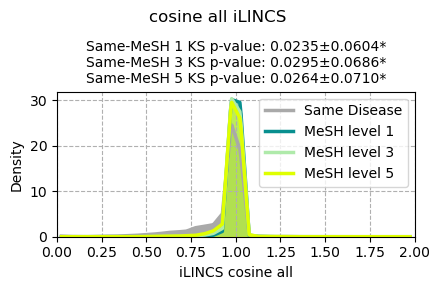

In [ ]:
# all

value_i = d_mesh_cosine[1]["interest"]
value_1 = d_mesh_cosine[1]["related"]
value_2 = d_mesh_cosine[3]["related"]
value_3 = d_mesh_cosine[5]["related"]

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "all"],
    save=True,
)

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


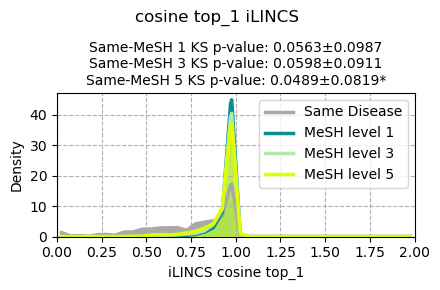

In [ ]:
# top k

top_k = 1

value_i = list()
for matrix in d_mesh_cosine[1]["interest"]:
    _matrix_values = np.empty((matrix.shape[0], top_k))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(
            matrix[i, :], k=top_k, percent=False, reverse=True
        )
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_cosine[1]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_cosine[3]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_cosine[5]["related"]:
    _matrix_values = np.empty((matrix.shape[0], top_k * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * top_k : (1 + j) * top_k] = get_top_k(
                sample, k=top_k, percent=False, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_1"],
    save=True,
)

cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


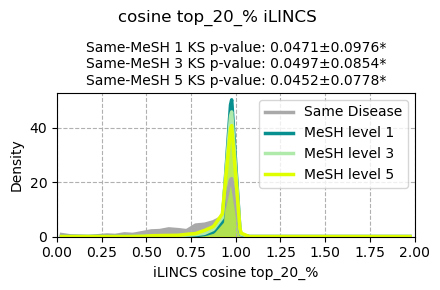

In [ ]:
# top k %

top_k = 0.2

value_i = list()
for matrix in d_mesh_cosine[1]["interest"]:
    n_columns = round(matrix.shape[1] * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns))
    # iterate through rows
    for i in range(matrix.shape[0]):
        _matrix_values[i] = get_top_k(matrix[i, :], k=top_k, percent=True, reverse=True)
    value_i.append(_matrix_values)


value_1 = list()
for matrix in d_mesh_cosine[1]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_1.append(_matrix_values)


value_2 = list()
for matrix in d_mesh_cosine[3]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_2.append(_matrix_values)

value_3 = list()
for matrix in d_mesh_cosine[5]["related"]:
    n_columns = round(matrix.shape[1] / 100 * top_k)
    _matrix_values = np.empty((matrix.shape[0], n_columns * 100))
    # iterate through rows
    for i in range(matrix.shape[0]):
        # iterate through samples
        for j in range(100):
            sample = np.array_split(matrix[i, :], 100)[j]
            _matrix_values[i, j * n_columns : (1 + j) * n_columns] = get_top_k(
                sample, k=top_k, percent=True, reverse=True
            )
    value_3.append(_matrix_values)

ks_p_values_1_mean, ks_p_values_1_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_1,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_2_mean, ks_p_values_2_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_2,
    resampling_1=False,
    resampling_2=True,
)


ks_p_values_3_mean, ks_p_values_3_std = get_ks_statistics_subsamples_all(
    list_matrix_1=value_i,
    list_matrix_2=value_3,
    resampling_1=False,
    resampling_2=True,
)

values_list = [value_i, value_1, value_2, value_3]
ks_values_list = [
    [ks_p_values_1_mean, ks_p_values_1_std],
    [ks_p_values_2_mean, ks_p_values_2_std],
    [ks_p_values_3_mean, ks_p_values_3_std],
]
labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

plot_metrics(
    values_list=values_list,
    ks_values_list=ks_values_list,
    labels=labels,
    vector_type=metric_evaluated,
    metric_list=["cosine", "top_20_%"],
    save=True,
)

2024-05-08 13:23:28,069 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-05-08 13:23:29,385 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


2024-05-08 13:23:30,733 - INFO - Nº of values: 100 100


cosine
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.  ]


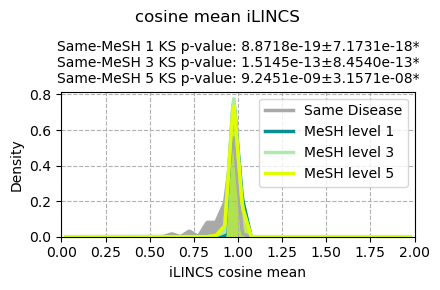

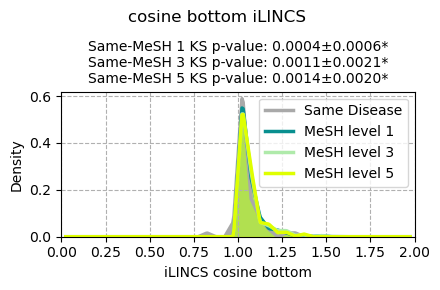

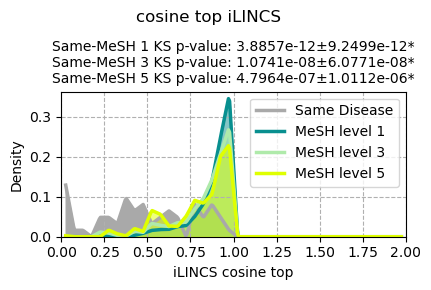

In [ ]:
operation_d = {"mean": np.mean, "top": np.min, "bottom": np.max}
for operation_type in ["mean", "bottom", "top"]:
    operation = operation_d.get(operation_type)
    value_i = [operation(matrix.flatten()) for matrix in d_mesh_cosine[1]["interest"]]

    value_1 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[1]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_1[j].append(operation(sample.flatten()))

    value_2 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[3]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_2[j].append(operation(sample.flatten()))

    value_3 = [[] for _ in range(100)]
    for matrix in d_mesh_cosine[5]["related"]:
        # iterate through columns
        for j in range(100):
            sample = np.array_split(matrix, 100, axis=1)[j]
            value_3[j].append(operation(sample.flatten()))

    logging.info(f"Nº of values: {len(value_1)} {len(value_2)}")

    # define statistics
    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_1[i])[1])
    ks_p_values_1_mean, ks_p_values_1_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_2[i])[1])
    ks_p_values_2_mean, ks_p_values_2_std = np.mean(ks_p_val), np.std(ks_p_val)

    ks_p_val = list()
    for i in range(100):
        ks_p_val.append(ks_2samp(value_i, value_3[i])[1])
    ks_p_values_3_mean, ks_p_values_3_std = np.mean(ks_p_val), np.std(ks_p_val)

    # Define plotting variables
    values_list = [value_i, flatten(value_1), flatten(value_2), flatten(value_3)]

    ks_values_list = [
        [ks_p_values_1_mean, ks_p_values_1_std],
        [ks_p_values_2_mean, ks_p_values_2_std],
        [ks_p_values_3_mean, ks_p_values_3_std],
    ]
    labels = ["Same Disease", "MeSH level 1", "MeSH level 3", "MeSH level 5"]

    plot_metrics(
        values_list=values_list,
        ks_values_list=ks_values_list,
        labels=labels,
        vector_type=metric_evaluated,
        metric_list=["cosine", operation_type],
        values_per_disease=False,
        save=True,
    )

### NN

In [ ]:
def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    average_precision_score,
)
import numpy as np


def get_k_precision(idxs, k, matrix):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs: list of indexes
        k: int
        matrix: np.array
    Returns:
        np.array
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    return np.sum(labels[idx_k], axis=1) / 3


def get_k_precision(idxs, k, matrix, top=True):
    """Get K Precision
    MATRIX DIAGONAL MUST BE FILLED IN!
    Args:
        idxs (list): indexes
        k (int): k values
        matrix (np.array): matrix of similarities
        top (bool): get top k or bottom k
    Returns:
        np.array: precision values
    """

    labels = np.zeros(matrix.shape[1])
    labels[idxs] = 1
    if top:
        idx_k = np.argpartition(matrix[idxs], -k, axis=1)[:, -k:]
    else:
        idx_k = np.argpartition(matrix[idxs], k, axis=1)[:, :k]
    return list(np.sum(labels[idx_k], axis=1))


# Example AUROC calculation using kNN for each disease signature
auroc_scores = {"correlation": [], "cosine": [], "euclidean": [], "disease": []}
auroc_scores = {"correlation": [], "disease": []}

# Assuming `data_matrix` is your feature matrix where rows are disease signatures
num_diseases = len(most_common_diseases)

copy_matrix_pearson_correlation = np.copy(matrix_pearson_correlation)
np.fill_diagonal(copy_matrix_pearson_correlation, 0)

copy_matrix_cosine_distance = np.copy(matrix_cosine_distance)
np.fill_diagonal(copy_matrix_cosine_distance, 1)

copy_matrix_euclidean_distance = np.copy(matrix_euclidean_distance)
np.fill_diagonal(copy_matrix_euclidean_distance, np.inf)


correlation_tp = list()
cosine_tp = list()
euclidean_tp = list()

for idx, disease in tqdm(enumerate(most_common_diseases)):

    # dsaids w/ diseases of interest
    QUERY = f"disease == @disease"
    df_query = df_matrix.query(QUERY)
    dsaids_interest = df_query["dsaid"].to_list()
    interest_idxs = [dsaids_matrix.index(d) for d in dsaids_interest]

    correlation_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_pearson_correlation)
    )

    cosine_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_cosine_distance, top=False)
    )
    euclidean_tp.append(
        get_k_precision(interest_idxs, 3, copy_matrix_euclidean_distance, top=False)
    )

del (
    copy_matrix_pearson_correlation,
    copy_matrix_cosine_distance,
    copy_matrix_euclidean_distance,
)

209it [00:00, 295.83it/s]


<Axes: >

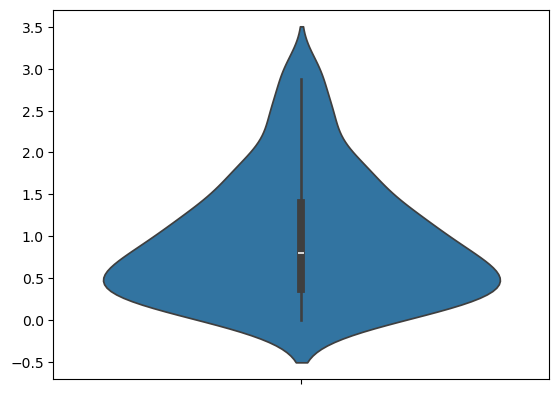

In [ ]:
sns.violinplot([np.mean(x) for x in correlation_tp])

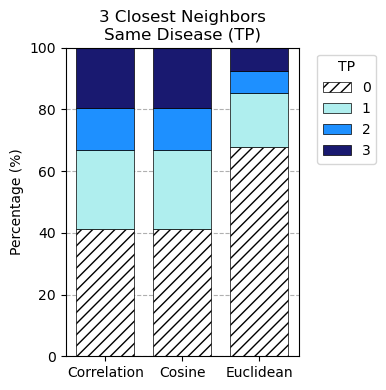

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data for each metric (assuming integers 0, 1, 2, 3 represent the count of nearest neighbors that are the same disease)
data_1 = flatten(correlation_tp)  # Correlation
data_2 = flatten(cosine_tp)  # Cosine
data_3 = flatten(euclidean_tp)  # Euclidean

# Bin edges for the categories
bins = np.array([0, 1, 2, 3, 4])

# define colors
colors = ["white", "paleturquoise", "#1E90FF", "midnightblue"]

# Calculate histogram data for each
counts_1, _ = np.histogram(data_1, bins=bins)
counts_2, _ = np.histogram(data_2, bins=bins)
counts_3, _ = np.histogram(data_3, bins=bins)

# Labels for the plot
metrics_labels = ["Correlation", "Cosine", "Euclidean"]
category_labels = [f"{i}" for i in range(4)]  # Labels for the legend

# Create the figure and axes
fig, ax = plt.subplots(figsize=(4, 4))

# Width of each stack segment
width = 0.75

# Convert counts to percentage
percentage_1 = counts_1 / len(data_1) * 100
percentage_2 = counts_2 / len(data_2) * 100
percentage_3 = counts_3 / len(data_3) * 100

# Stack the bars for each metric
for i, counts in enumerate([percentage_1, percentage_2, percentage_3]):
    bottom_shift = np.cumsum([0] + counts.tolist())[
        :-1
    ]  # Calculate the bottom position for each stack
    for j in range(len(counts)):

        if j == 0:
            ax.bar(
                metrics_labels[i],
                counts[j],
                bottom=bottom_shift[j],
                width=width,
                label=f"{category_labels[j]}" if i == 0 else "",
                color=colors[j],
                zorder=2,
                edgecolor="black",
                linewidth=0.5,
                hatch="///",
            )
        else:
            ax.bar(
                metrics_labels[i],
                counts[j],
                bottom=bottom_shift[j],
                width=width,
                label=f"{category_labels[j]}" if i == 0 else "",
                color=colors[j],
                zorder=2,
                edgecolor="black",
                linewidth=0.5,
            )

# Add a legend and axis labels
ax.set_ylabel("Percentage (%)")
ax.set_title("3 Closest Neighbors\nSame Disease (TP)")
ax.legend(title="TP", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.ylim(0, 100)
# Show the plot
plt.grid(linestyle="--", zorder=-3)
plt.tight_layout()

plt.savefig(
    os.path.join(
        "..",
        "results",
        "figures",
        "DiSignAtlas",
        f"nn.{metric_evaluated}.mesh.{sparsity}.png",
    ),
    dpi=300,
    bbox_inches="tight",
)

## Testing Area